# Modelisation


**[Data preprocessing et mise en place de la pipeline](#pi)**

**[Métriques utilisées](#me)**

**[Modélisation](#mo)**

**[Resultat des meilleurs scores par modeles](#res)**

**[Optimisation des resultats](#op)**

**[Resultat des meilleurs scores par modeles apres optimisation](#op2)**

**[Comparaisons des predictions par defaults et custom](#cu)**

**[Test avec energystarScore](#en)**

**[Comparaisons des resultats ](#sc)**

**[Selection des trois meilleurs algorithme](#sl)**



In [1]:
# https://contrib.scikit-learn.org/category_encoders/
# A set of scikit-learn-style transformers for encoding categorical variables into numeric with different techniques. 
# While ordinal, one-hot, and hashing encoders have similar equivalents in the existing scikit-learn version, 
# the transformers in this library all share a few useful properties:
# First-class support for pandas dataframes as an input (and optionally as output)
# Can explicitly configure which columns in the data are encoded by name or index, or infer non-numeric columns regardless of input type
# Can drop any columns with very low variance based on training set optionally
# Portability: train a transformer on data, pickle it, reuse it later and get the same thing out.
# Full compatibility with sklearn pipelines, input an array-like dataset like any other transformer
!pip install category_encoders
# !pip install pandas --upgrade

     |████████████████████████████████| 82 kB 361 kB/s 


In [ ]:
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils import check_array
from sklearn import decomposition
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder,RobustScaler,FunctionTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
# Cross validation 
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.model_selection import cross_validate,validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNet
from sklearn.svm import LinearSVR
# Métrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import accuracy_score, r2_score

from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import set_config
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from utils import plot_learning_curve,plot_cross_val_predi
from sklearn.linear_model import Ridge
import timeit
from scipy.stats import loguniform
from sklearn.exceptions import ConvergenceWarning,FitFailedWarning
from IPython.core.display import display, HTML
import warnings

def fxn():
    warnings.warn("ignore", ConvergenceWarning)
    warnings.warn("ignore", FitFailedWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# from sklearn.exceptions import ConvergenceWarning
# ConvergenceWarning('ignore')
# plt.style.use("seaborn-muted")
plt.style.use("bmh")

In [3]:
pd.set_option('display.max_columns', None ) #pour afficher toutes les colonnes
pd.set_option('display.max_rows', None ) #pour afficher toutes les lignes
pd.set_option('display.max_colwidth', None)

Suppression de la colonne ENERGYSTARScore pour le moment

In [4]:
seattle=pd.read_csv('seattle_cleaned.csv', sep=",") #3376 rows × 46 columns
seattle.shape
seattle = seattle.drop(['Unnamed: 0','ENERGYSTARScore','DataYear'], axis=1)
seattle.shape

seattle = seattle.dropna(axis=0)
seattle.shape

(1343, 18)

In [5]:
target_variable = 'TotalGHGEmissions'
display(HTML('<h1 style="text-align: center;">Predictions pour {}'.format(target_variable)+'</h1>'))

<a name='pi'></a>
# data preprocessing et mise en place de la pipeline

**Nous allons mettre en place notre pipeline de traitement de nos features, par types**

   * Numeriques
   * Categorielles
   * Boolean (indication du type d energie autre que  l electricite
   
Les variables catégorielles sont transformés par un target_encoder. Cela consiste à remplacer la valeur de chaque variable catégorielle par la moyenne de la cible des individus ayant la même valeur pour la variable catégorielle


Nous normaliserons nos donnees avec un **RobustScaler** (equivalent a StandardScaler mais gere mieux les outliers)


Pour assurer la normalite des donnees , nous allons les transformer en log grace  a **TransformedTargetRegressor**

In [6]:
echantillon = seattle.copy()
echantillon = echantillon.drop(['Latitude','Longitude','GFABuildingRate','GFAParkingRate',], axis=1)
# numericColumns = ['NumberofBuildings', 'NumberofFloors',  'BuildingAge','Electricity', 'NaturalGas', 'SteamUse', 'GFAPerBuilding', 'GFAPerFloor', 'GFABuildingRate', 'GFAParkingRate']
# numericColumns = ['NumberofBuildings', 'NumberofFloors',  'BuildingAge','Electricity', 'NaturalGas', 'SteamUse', 'GFAPerBuilding', 'GFAPerFloor']
numericColumns = ['NumberofBuildings', 'NumberofFloors',  'BuildingAge','Electricity',   'GFAPerBuilding', 'GFAPerFloor','NaturalGas', 'SteamUse']

qualitativesColumns = list(echantillon.select_dtypes(include=['object']))
#mettre une variable binaire a utiliser pour NaturalGas et SteamUse
booleanColumns = ['NaturalGas', 'SteamUse']

X = echantillon.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)
# X = echantillon.drop(['SiteEnergyUse(kBtu)'], axis=1)
# Y = echantillon[['SiteEnergyUse(kBtu)']]
Y = echantillon.loc[:,target_variable]


def boolean_transformation(X):
    return X.astype(int)


boolean_pipeline = Pipeline([
    ('otherEnergy',FunctionTransformer(boolean_transformation))
                            ])

# Labelize les variables catégorielles et les ajoute aux variables numériques transformés
categorical_pipeLine = Pipeline([
#     ('OneHotEncoder', OneHotEncoder(handle_unknown = 'ignore') ),
#     ('SVD',TruncatedSVD(n_components=5, n_iter=7, random_state=42))    
    #meilleurs resultats avec ses parametres
    ('target', TargetEncoder()),    
    # ('std_scaler', StandardScaler()), # Normalisation des données  

     ('rob_scaler', RobustScaler())  
    
])

# Pipeline pour les variables numériques
numerical_pipeline = Pipeline([
    ('rob_scaler', RobustScaler()), # Normalisation des données
#     ('pca', decomposition.PCA())
])


preprocessor = ColumnTransformer([
        ("boolean",boolean_pipeline, booleanColumns), 
        ("categorical", categorical_pipeLine, qualitativesColumns),   
        ("numeric", numerical_pipeline, numericColumns),        
    ])


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],X_test.shape[0]))

Entrainement: 1074 lignes,
Test: 269 lignes.



Nous allons tester respectivement les modeles suivants avec GridSearchCV:
 <code> 
 
    'linear':LinearRegression(),
    'dummy': DummyRegressor(),
    'elastic_net' : ElasticNet(),    
    'ridge':Ridge(),    
    'lasso':Lasso(),   
    'svr': SVR(),
    'random_forest': RandomForestRegressor(),
    'extra_tree': ExtraTreesRegressor(),
    'gradient_boosting' : GradientBoostingRegressor()
    
</code>    

Dans un premier temps , par defaut , puis avec des parametres custom

<a name='me'></a>
## Métriques utilisées

Dans cette partie, deux métriques sont utilisés : la MAE et la RMSE

La RMSE est plus sensible que la MAE aux valeurs s'écartant de la normale, ce qui permet de mieux traiter les écarts importants, c'est pourquoi la RMSE est préféré et sera utilisé pour la séléction des modèles finaux. En revanche la MAE sert à titre indicatif

Une autre métrique est utilisé en complément pour avoir une idée plus parlante de la qualité d'un modèle, il s'agit du coefficient de détermination R2

Nos metriques vont s exprimer dans l unite de la variable cible, ici ce seras  en unite CO2

Erreur quadratique moyenne

$ MSE = \frac{1}{n} \sum_{i=1}^n (f(x_i)-y_i)^2\ $

racine de l erreur quadratique moyenne

$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^n (f(x_i)-y_i)^2}$



$RSE = \frac{\sum_{i=1}^n (y_i - f(x_i))^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$

coefficient de détermination.

$R^2 = 1 - RSE$ 

SciKit-learn nous calcul directement certaines metriques, nous lui specifions dans un dictionnary les metriques voulues
<code>
    {
    'r2' : 'r2',
    'mse' : 'neg_mean_squared_error', 
    'mae' : 'neg_mean_absolute_error'
}</code>

<a name='mo'></a>
# modélisation

Pour notre modelisation , nous allons tenter de tester tous nos modeles de regression disponibles , ainsi que les comparer entre eux par nos metriques.(RMSE,MAE et r2)

Pour cela nous avons creer une classe <code>EstimatorSelectionByAlgobyDefault</code> recuperant une liste de dictionnary (nom modele --> Modele de regression a tester), celui ci les testera un a un dans un GRIDSEARCHCV et renverra les resultats de la regression 


Nous ferons de meme avec les hyperparamtres avec une autre classe <code>EstimatorSelectionByAlgo</code>:

In [7]:
import warnings
warnings.filterwarnings("ignore")
class EstimatorSelectionByAlgobyDefault:

    
    def __init__(self, models,useLog=True):
        self.models = models
        self.keys = models.keys()
        self.grid_searches = {}
        self.useLog = useLog
        self.scorer = {}
        self.cv_results_ = {}
        self.bestParams={}
        self.scoring = {
                        "r2" : "r2",
                        "mse" : "neg_mean_squared_error", 
                        "mae" : "neg_mean_absolute_error"
                    }
#         self.kfold = KFold(n_splits=5, random_state=0) 
        self.kfold = KFold(n_splits=5) 

    #Methode qui test un modele de regression sans parametres et stocke les resultats dans plusieurs dictionnary
    def fit(self, X, y):
        starttotaltime = timeit.default_timer()
        for model_name in self.keys:
            print('Running GridSearchCV for %s.' % model_name)     
            starttime = timeit.default_timer()     
            model = self.models[model_name]
            print('model',model)
            if(self.useLog):
                pipeline =  Pipeline([
                ('preprocessor', preprocessor),
                (model_name,TransformedTargetRegressor(regressor=model, func=np.log1p,inverse_func=np.expm1)), 
                ])
            else:
                pipeline =  Pipeline([
                ('preprocessor', preprocessor),
                (model_name,model) 
                        ])
       
            #GridSearchCV
            #RandomizedSearchCV
            grid_search = GridSearchCV(
                                        pipeline, 
                                        {},
                                        scoring = self.scoring,
                                        return_train_score = True,
                                        refit='mse',
                                        cv = self.kfold,
                                      n_jobs=-1)
            grid_search.fit(X, y)
            scorer = grid_search.best_estimator_
            self.scorer[model_name] = scorer
            self.grid_searches[model_name] = grid_search
            self.cv_results_[model_name] = grid_search.cv_results_
            elapsed = timeit.default_timer() - starttime
            self.bestParams[model_name] = grid_search.best_params_
            print('training {} model done'.format(model_name))
            print("elapsed time {:.2f}s".format(elapsed))
        print('All training done.')
        elapsed = timeit.default_timer() - starttotaltime
        print("total time {:.2f}s".format(elapsed))

    #renvoie les best parametres    
    def getBestParams(self):
        return self.bestParams
    
    def showBestParams(self,useindex=False):
        frames =[]
        result = pd.DataFrame()
        for name, bestParams in self.bestParams.items():      
            frame = pd.DataFrame()
            frame['estimator'] = [name]  
            frame['best_params'] = [bestParams]
            frames.append(frame)
        result = pd.concat(frames) 
        result = result.reset_index()
        if(useindex):
            result.set_index('estimator', inplace=True)
        result = result.drop([ 'index'], 1)
        return result         
  
    
    def getGetScorer(self):
        return self.scorer 
    
    #renvoie les resulats cv_results de gridsearch
    def getCvResults(self):
        return sel.cv_results_
    

    #renvoie les resultats grid_search par modele , ordonner par le rank mse
    def getScore_summary(self, sort_by='rank_test_mse'):
        frames = []
        for name, grid_search in self.grid_searches.items():            
            frame = pd.DataFrame(grid_search.cv_results_)            
            frame['estimator'] = len(frame)*[name]
            frames.append(frame)
        df = pd.concat(frames)        
        df = df.reset_index()
        df.set_index('estimator', inplace=True)
        df = df.sort_values([sort_by], ascending=True)
        df = df.drop([ 'index'], 1)
        return df


    #selectionne les meilleurs resulats par modele contenu dans cv_results et recupere r2,mae et rmse
    def getBestModeleScore_summaryR2(self):
        frames=[]
        for name, grid_search in self.grid_searches.items():      
            results = pd.DataFrame(grid_search.cv_results_)
            frame = pd.DataFrame()
            frame['estimator'] = [name]
            frame["R2"] = ( round(abs(results.iloc[grid_search.best_index_]["mean_test_r2"]), 3))
            # frame['duration'] = round(results.iloc[grid_search.best_index_]["mean_score_time"], 3)      
            frames.append(frame)
        df = pd.concat(frames) 
        df = df.reset_index()
        df.set_index('estimator', inplace=True)
        df = df.drop([ 'index'], 1)
        return df 

    #affiche les meilleurs resulats par modele contenu dans cv_results et recupere r2,mae et rmse
    def getBestModeleScore_graphR2(self):          
        plt.rcParams['font.size'] = '10'
        ax = self.getBestModeleScore_summaryR2().plot(kind='bar',figsize=(15,6)) 
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

        plt.legend(loc=2)
        plt.title('Resultats des meilleurs R2 scores par modeles sans parametres')
        plt.show()         

    #selectionne les meilleurs resulats par modele contenu dans cv_results et recupere r2,mae et rmse
    def getBestModeleScore_summary(self,showR2=False):
        frames=[]
        for name, grid_search in self.grid_searches.items():      
            results = pd.DataFrame(grid_search.cv_results_)
            frame = pd.DataFrame()
            frame['estimator'] = [name]
            if(showR2):
              frame["R2"] = ( round(abs(results.iloc[grid_search.best_index_]["mean_test_r2"]), 3))
            frame["MAE"] = round(abs(results.iloc[grid_search.best_index_]["mean_test_mae"]), 3)
            frame["RMSE"] = round(math.sqrt(abs(results.iloc[grid_search.best_index_]["mean_test_mse"])), 3)
            # frame['duration'] = round(results.iloc[grid_search.best_index_]["mean_score_time"], 3)      
            frames.append(frame)
        df = pd.concat(frames) 
        df = df.reset_index()
        df.set_index('estimator', inplace=True)
        df = df.drop([ 'index'], 1)
        return df  
    
    #affiche les meilleurs resulats par modele contenu dans cv_results et recupere r2,mae et rmse
    def getBestModeleScore_graph(self):          
        plt.rcParams['font.size'] = '10'
        ax = self.getBestModeleScore_summary().plot(kind='bar',figsize=(15,6)) 
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

        plt.legend(loc=2)
        plt.title('Resultats des meilleurs scores par modeles sans parametres')
        plt.show()  
        

    #selectionne les meilleurs resulats de test de predictions par modele(estimator) contenu dans  et recupere r2,mae et rmse        
    def getBestModeleScore_scorePrediction(self,useIndex=False,showR2=False):
        frames =[]
        result = pd.DataFrame()
        for name, grid_search in self.grid_searches.items():      
            frame = pd.DataFrame()
            #grid_search.predict(X_test) is equivalent to grid_search.best_estimator_.predict(X_test)
            y_pred = grid_search.predict(X_test) 
            frame['estimator'] = [name]  
            if(showR2):
              frame['R2'] = round((r2_score(y_test, y_pred)), 5)
            frame['MAE'] = round(mean_absolute_error(y_test, y_pred), 3)
            frame['RMSE'] = round(mean_squared_error(y_test, y_pred, squared=False), 3)
            frames.append(frame)
        result = pd.concat(frames) 
        result = result.reset_index()
        result.set_index('estimator', inplace=True)
        result = result.drop([ 'index'], 1)
        return result   
    
    #affiche les meilleurs resulats de test de predictions par modele(estimator) contenu dans  et recupere r2,mae et rmse 
    def getBestModeleScore_graphpredictions(self):          
        plt.rcParams['font.size'] = '10'
        ax = self.getBestModeleScore_scorePrediction(True).plot(kind='bar',figsize=(15,6)) 
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

        plt.legend(loc=2)
        plt.title('Resultats des meilleurs predictions par modeles')
        plt.show()                                 


    #   Genere 3 graphiques: la courbe d'apprentissage du test et de l'entraînement, la courbe d'entraînement
    #  la courbe échantillons vs temps d'ajustement, la courbe temps d'ajustement vs score.
    def getLearningCurveByName(self,model_name,X_train,y_train):
        ## Results from grid search
        grid = self.grid_searches[model_name]
        title = "learning curve for model {}".format(model_name)
        estimator = grid.best_estimator_
        plot_learning_curve(
            estimator, title, X_train, y_train, ylim=(0.0, 1.01), cv=self.kfold, n_jobs=4
        )
        plt.show()    

    #affiche la validation entre les valeurs reels et predites    
    def showPredictionbyName(self,name,target,X_train,y_train):
        plot_cross_val_predi(self.grid_searches[name].best_estimator_, name, target, X_train, y_train, cv=self.kfold)

    #affiche les features importances par modeles
    def showFeaturesImportancesbyName(self, name_model, X_train, y_train, scoring=None):
        results = permutation_importance(self.grid_searches[name_model].best_estimator_, X_train, y_train, scoring=scoring)
        importance = pd.DataFrame({
                            "feature" : X_train.columns,
                            "importance" : results.importances_mean
                        })

        importance = importance.sort_values("importance")   
        fig = plt.subplots(figsize=(8, 6))
        plot = sns.barplot(data=importance, y=importance["feature"], x=importance["importance"])
        plt.title(  "Features Importance for model "+name_model, fontdict={ "fontsize": 16, "fontweight": "normal" })
        plt.xlabel("Importance")
        plt.ylabel("Features")
        plt.tight_layout()

        plt.show()        
            
        
    
    
modeldefaults = {   
    'dummy': DummyRegressor(),
    'linear':LinearRegression(),
    'elastic_net' : ElasticNet(),    
    'ridge':Ridge(),    
    'lasso':Lasso(),   
    'svr': SVR(),
    'random_forest': RandomForestRegressor(),
    'extra_tree': ExtraTreesRegressor(),
    'gradient_boosting' : GradientBoostingRegressor(),
}


algo_estimatorDefaults = EstimatorSelectionByAlgobyDefault(modeldefaults,True)
algo_estimatorDefaults.fit(X_train,y_train)

Running GridSearchCV for dummy.
model DummyRegressor()
training dummy model done
elapsed time 1.34s
Running GridSearchCV for linear.
model LinearRegression()
training linear model done
elapsed time 0.84s
Running GridSearchCV for elastic_net.
model ElasticNet()
training elastic_net model done
elapsed time 0.91s
Running GridSearchCV for ridge.
model Ridge()
training ridge model done
elapsed time 0.93s
Running GridSearchCV for lasso.
model Lasso()
training lasso model done
elapsed time 0.96s
Running GridSearchCV for svr.
model SVR()
training svr model done
elapsed time 1.11s
Running GridSearchCV for random_forest.
model RandomForestRegressor()
training random_forest model done
elapsed time 1.93s
Running GridSearchCV for extra_tree.
model ExtraTreesRegressor()
training extra_tree model done
elapsed time 1.59s
Running GridSearchCV for gradient_boosting.
model GradientBoostingRegressor()
training gradient_boosting model done
elapsed time 0.70s
All training done.
total time 10.31s


<a name='res'></a>
## resultat des meilleurs scores par modeles

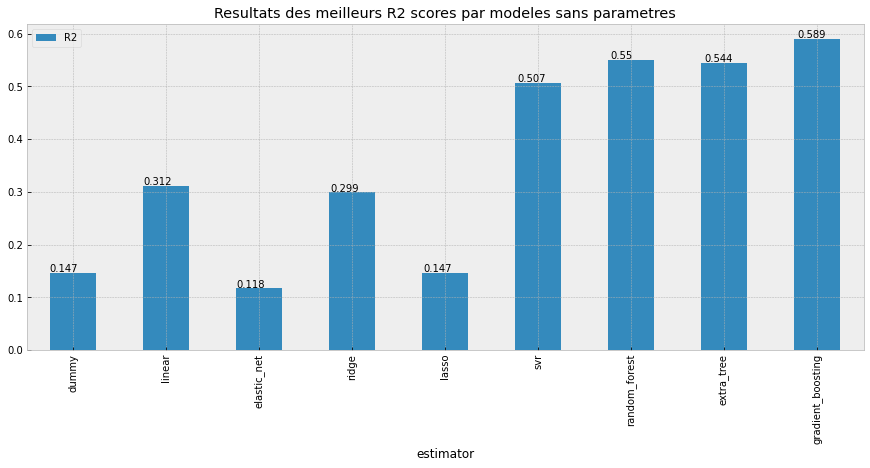

In [8]:
algo_estimatorDefaults.getBestModeleScore_graphR2()

In [9]:
algo_estimatorDefaults.getBestModeleScore_summary(showR2=True)

R2     MAE    RMSE
estimator                               
dummy              0.147  57.158  97.847
linear             0.312  38.456  76.179
elastic_net        0.118  56.000  96.561
ridge              0.299  38.723  76.859
lasso              0.147  57.158  97.847
svr                0.507  34.307  64.353
random_forest      0.550  33.056  61.249
extra_tree         0.544  32.789  61.861
gradient_boosting  0.589  31.622  58.672

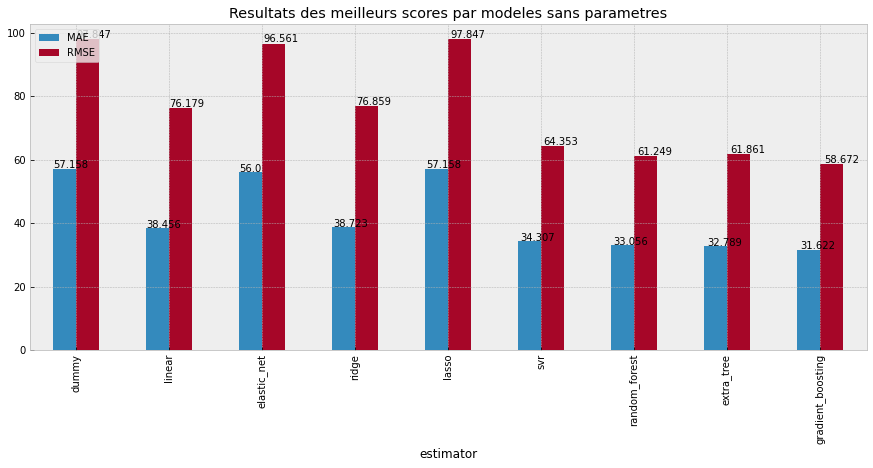

In [10]:
algo_estimatorDefaults.getBestModeleScore_graph()

## resultat des meilleurs scores par predictions

In [11]:
algo_estimatorDefaults.getBestModeleScore_scorePrediction(showR2=True)

R2     MAE     RMSE
estimator                                  
dummy             -0.12229  52.105   85.709
linear            -3.54234  48.053  172.432
elastic_net       -0.08350  50.818   84.216
ridge             -8.47365  52.953  249.021
lasso             -0.12229  52.105   85.709
svr                0.57506  30.697   52.740
random_forest      0.64600  26.268   48.137
extra_tree         0.60638  27.082   50.759
gradient_boosting  0.67617  26.102   46.040

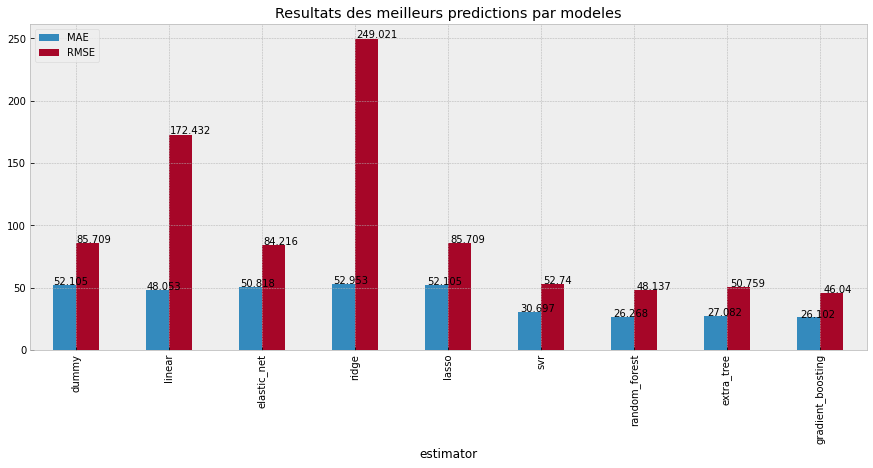

In [12]:
algo_estimatorDefaults.getBestModeleScore_graphpredictions()

**Par default les modeles ensemblistes gradient boosting , extra tree et random forest on les meilleurs resultats**


<a name='op'></a>
# Optimisation des resultats

Nous allons donc faire la meme chose avec en plus des plages d hyperparametres a tester pour chaque modeles

In [13]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import RidgeCV
from sklearn import linear_model

class EstimatorSelectionByAlgo:

    
    def __init__(self, models, params,useLog=True):
        self.models = models
        self.keys = models.keys()
        self.params = params
        self.grid_searches = {}
        self.useLog = useLog
        self.bestParams = {}
        self.scorer = {}
        self.cv_results = {}
        self.scoring = {
                        "r2" : "r2",
                        "mse" : "neg_mean_squared_error", 
                        "mae" : "neg_mean_absolute_error"
                    }
#         self.kfold = KFold(n_splits=5, random_state=0) 
        self.kfold = KFold(n_splits=5) 
#         self.kfold = StratifiedKFold(n_splits=5)
       
    
    def fit(self, X, y):
        starttotaltime = timeit.default_timer()
        for model_name in self.keys:
            print('Running GridSearchCV for %s.' % model_name)     
            starttime = timeit.default_timer()
            model = self.models[model_name]
            params = self.params[model_name]
            print('training model',model)
            if(self.useLog):
                pipeline =  Pipeline([
                ('preprocessor', preprocessor),
                (model_name,TransformedTargetRegressor(regressor=model, func=np.log1p,inverse_func=np.expm1)), 
                ])
            else:
                pipeline =  Pipeline([
                ('preprocessor', preprocessor),
                (model_name,model) 
                        ])                      
            #GridSearchCV
            #RandomizedSearchCV
            grid_search = GridSearchCV(
                                    pipeline, 
                                    params,
                                    scoring = self.scoring,
                                    return_train_score = True,
                                    refit='mse',
                                    cv = self.kfold,
                                    n_jobs=-1
                                    )
#             print(grid_search.get_params().keys())
            grid_search.fit(X, y)
            self.bestParams[model_name] = grid_search.best_params_
            self.scorer[model_name] = grid_search.best_estimator_
            self.grid_searches[model_name] = grid_search
            self.cv_results[model_name] = grid_search.cv_results_
            
            
            elapsed = timeit.default_timer() - starttime
            print('training {} model done'.format(model_name))
            print("elapsed time {:.2f}s".format(elapsed))
        print('All training done.')
        elapsed = timeit.default_timer() - starttotaltime
        print("total time {:.2f}s".format(elapsed))
        
        
    def getBestParams(self):
        return self.bestParams
    
    def showBestParams(self,useindex=False):
        frames =[]
        result = pd.DataFrame()
        for name, bestParams in self.bestParams.items():      
            frame = pd.DataFrame()
            frame['estimator'] = [name]  
            frame['best_params'] = [bestParams]
            frames.append(frame)
        result = pd.concat(frames) 
        result = result.reset_index()
        if(useindex):
            result.set_index('estimator', inplace=True)
        result = result.drop([ 'index'], 1)
        return result     
    
    def getGetScorer(self):
        return self.scorer 
    
    def getCvResults(self):
        return sel.cv_results_
    

    
    def getScore_summary(self, sort_by='rank_test_mse'):
        frames = []
        for name, grid_search in self.grid_searches.items():            
            frame = pd.DataFrame(grid_search.cv_results_)
            
            #recuperation du meilleur modele
            #utiliser best_estimator egalement
#             best_model_index = grid_search.best_index_
#             score = [(grid_search.cv_results_["split" + str(i) + "_test_MSE"][best_model_index]) for i in range(5)]
#             print(score)            
#             mean_score, std_score = np.mean(score), np.std(score)                                    
#             # Making the prediction using the testing data
#             y_pred = grid_search.predict(X_test)  
#             frame['rmse_mean'] = mean_score
#             frame['variance'] = std_score
#             frame['score_train'] = -grid_search.score(X_train,y_train)
#             frame['score_test'] = -grid_search.score(X_test, y_test)        
#             frame['rmse'] = np.sqrt(mean_squared_error(y_test,y_pred))
#             frame['mae'] = mean_absolute_error(y_test,y_pred)            
#             frame = frame.filter(regex='^(?!.*param_).*$')
            frame['estimator'] = len(frame)*[name]
#             frame = frame[['rank_test_MSE','estimator','rmse','mae','mean_fit_time','rmse_mean','variance']]
            frames.append(frame)
        df = pd.concat(frames)        
        df = df.reset_index()
        df.set_index('estimator', inplace=True)
        df = df.sort_values([sort_by], ascending=True)
        df = df.drop([ 'index'], 1)
        return df    
    
     #retourne les meilleurs resulats par modele contenu dans cv_results et recupere r2,mae et rmse
    def getBestModeleScore_summary(self,useIndex=False,showR2=False):
        frames=[]
        for name, grid_search in self.grid_searches.items():      
            results = pd.DataFrame(grid_search.cv_results_)
            frame = pd.DataFrame()
            #frame = frame.filter(regex='^(?!.*param_).*$')
            frame['estimator'] = [name]
            if(showR2):
              frame["R2"] = ( round(abs(results.iloc[grid_search.best_index_]["mean_test_r2"]), 3))
            frame["MAE"] = round(abs(results.iloc[grid_search.best_index_]["mean_test_mae"]), 3)
            frame["RMSE"] = round(math.sqrt(abs(results.iloc[grid_search.best_index_]["mean_test_mse"])), 3)
            # frame['duration'] = round(results.iloc[grid_search.best_index_]["mean_score_time"], 3)      
            frames.append(frame)
        df = pd.concat(frames) 
        df = df.reset_index()
        if(useIndex):
            df.set_index('estimator', inplace=True)
        df = df.drop([ 'index'], 1)
        return df  

    #selectionne les meilleurs resulats par modele contenu dans cv_results et recupere r2,mae et rmse
    def getBestModeleScore_summaryR2(self):
        frames=[]
        for name, grid_search in self.grid_searches.items():      
            results = pd.DataFrame(grid_search.cv_results_)
            frame = pd.DataFrame()
            frame['estimator'] = [name]
            frame["R2"] = ( round(abs(results.iloc[grid_search.best_index_]["mean_test_r2"]), 3))
            # frame['duration'] = round(results.iloc[grid_search.best_index_]["mean_score_time"], 3)      
            frames.append(frame)
        df = pd.concat(frames) 
        df = df.reset_index()
        df.set_index('estimator', inplace=True)
        df = df.drop([ 'index'], 1)
        return df 

    #affiche les meilleurs resulats par modele contenu dans cv_results et recupere r2,mae et rmse
    def getBestModeleScore_graphR2(self):          
        plt.rcParams['font.size'] = '10'
        ax = self.getBestModeleScore_summaryR2().plot(kind='bar',figsize=(15,6)) 
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

        plt.legend(loc=2)
        plt.title('Resultats des meilleurs R2 scores par modeles avec parametres ')
        plt.show()          

    def getBestModeleScore_graph(self):          
        plt.rcParams['font.size'] = '10'
        ax = self.getBestModeleScore_summary(True).plot(kind='bar',figsize=(15,6)) 
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

        plt.legend(loc=2)
        plt.title('Resultats des meilleurs scores par modeles apres hyperparametrisations')
        plt.show()  
    
     #renvoie les meilleurs resulats par modele contenu tester sur les variables test
    def getBestModeleScore_scorePrediction(self,useIndex=False, showR2=False):
        frames =[]
        result = pd.DataFrame()
        for name, grid_search in self.grid_searches.items():      
            frame = pd.DataFrame()
            #grid_search.predict(X_test) is equivalent to grid_search.best_estimator_.predict(X_test)
            y_pred = grid_search.predict(X_test) 
            frame['estimator'] = [name]  
            if(showR2):
              frame['R2'] = round((r2_score(y_test, y_pred)), 5)
            frame['MAE'] = round(mean_absolute_error(y_test, y_pred), 3)
            frame['RMSE'] = round(mean_squared_error(y_test, y_pred, squared=False), 3)
            
#             errors = abs(y_pred - y_test)
#             mape = 100 * np.mean(errors / y_test)
#             frame['accurracy'] = round(100 - mape, 4)            
            
            
            frames.append(frame)
        result = pd.concat(frames) 
        result = result.reset_index()
        if(useIndex):
            result.set_index('estimator', inplace=True)
        result = result.drop([ 'index'], 1)
        return result  
    
    #affiche les meilleurs resulats par modele contenu tester sur les variables test
    def getBestModeleScore_graphpredictions(self):          
        plt.rcParams['font.size'] = '10'
        ax = self.getBestModeleScore_scorePrediction(True).plot(kind='bar',figsize=(15,6)) 
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

        plt.legend(loc=2)
        plt.title('Resultats des meilleurs predictions par modeles apres hyperparametrisations')
        plt.show()      
    

      
      
    #fonction qui creer une nouvelle validation curve le test sur le meilleurs modeles pour chaque
    #hyperparametres
    def showValidationCurvebyName(self,model_name,X_train,y_train): 
        gridsearch = self.grid_searches[model_name]
        params = self.params[model_name]
        fig, axes = plt.subplots(1, len(params), figsize = (6*len(params), 5),sharey='row')
        axes[0].set_ylabel("Score", fontsize=25)
        plt.suptitle("Validation Curve for model :{}".format(model_name), size=15)
        for idx, (param_name, param_range) in enumerate(sorted(params.items())):
            train_scores, test_scores = validation_curve(
                                            estimator=gridsearch.best_estimator_,
                                            X=X_train,
                                            y=y_train,
                                            cv=self.kfold,
                                            param_name=param_name,
                                            param_range=param_range
            )

            train_mean = np.mean(train_scores, axis=1)
            test_mean = np.mean(test_scores, axis=1)

            axes[idx].plot(param_range, train_mean,
                     marker='o', markersize=5,
                     color='r', label='Training Accuracy')
            axes[idx].plot(param_range, test_mean,
                     marker='o', markersize=5,
                     color='g', label='Validation Accuracy')
            axes[idx].set_title(param_name,fontsize = 14)
            
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)
        fig.subplots_adjust(bottom=0.25, top=0.85)  
        plt.show()         
                      
    #fonction qui test les resultats de la validation curve a partir des resultats gridsearch cv_results_
    def showValidationCurveInGCCVResultsByMetric(self,model_name,metric):
        #metric r2 mae ou mse
        ## Results from grid search
        grid = self.grid_searches[model_name]
        results = grid.cv_results_
        means_test = results['mean_test_'+metric]
        stds_test = results['std_test_'+metric]
        means_train = results['mean_train_'+metric]
        stds_train = results['std_train_'+metric]
        ## Getting indexes of values per hyper-parameter
        masks=[]
        masks_names= list(grid.best_params_.keys())
        for p_k, p_v in grid.best_params_.items():
            masks.append(list(results['param_'+p_k].data==p_v))
        params=grid.param_grid
        ## Ploting results
        fig, ax = plt.subplots(1, len(params), figsize = (6*len(params), 5),sharey='row')
        ax[0].set_ylabel("Score")
        plt.suptitle("Validation Curve in cv_results for {} metric:{}".format(model_name,metric), size=15)        
        pram_preformace_in_best = {}
        for i, p in enumerate(sorted(masks_names)):
            m = np.stack(masks[:i] + masks[i+1:])
            pram_preformace_in_best
            best_parms_mask = m.all(axis=0)
            best_index = np.where(best_parms_mask)[0]
            x = np.array(params[p])
            y_1 = np.array(means_test[best_index])
            e_1 = np.array(stds_test[best_index])
            y_2 = np.array(means_train[best_index])
            e_2 = np.array(stds_train[best_index])
            ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test',color='g')
            ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' ,color='r')
            ax[i].set_xlabel(p.upper())   
        handles, labels = ax[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)
        fig.subplots_adjust(bottom=0.25, top=0.85)  
        plt.show()  

#     Generate 3 plots: the test and training learning curve, the training
#     samples vs fit times curve, the fit times vs score curve.
    def getLearningCurveByName(self,model_name,X_train,y_train):
        ## Results from grid search
        grid = self.grid_searches[model_name]
        title = "learning curve for model {}".format(model_name)
        estimator = grid.best_estimator_
        # plot_learning_curve(
        #     estimator, title, X_train, y_train, ylim=(0.1, 1.01), cv=self.kfold, n_jobs=4
        # )
        estimator = grid.best_estimator_
        plot_learning_curve(
            estimator, title, X_train, y_train,ylim=None, cv=self.kfold, n_jobs=4
        )        
        plt.show()    
        
    #Show validation between real values vs predicted values        
    def showPredictionbyName(self,name,target,X_train,y_train):
        plot_cross_val_predi(self.grid_searches[name].best_estimator_, name, target, X_train, y_train, cv=self.kfold)

    #Show features importances for a model
    def showFeaturesImportancesbyName(self, name_model, X_train, y_train, scoring=None):
        results = permutation_importance(self.grid_searches[name_model].best_estimator_, X_train, y_train, scoring=scoring)
        importance = pd.DataFrame({
                            "feature" : X_train.columns,
                            "importance" : results.importances_mean
                        })

        importance = importance.sort_values("importance")   
        fig = plt.subplots(figsize=(8, 6))
        plot = sns.barplot(data=importance, y=importance["feature"], x=importance["importance"])
        plt.title(  "Features Importance for model "+name_model, fontdict={ "fontsize": 16, "fontweight": "normal" })
        plt.xlabel("Importance")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.show()  
        
    #Show ridge or lasso coefficent alpha   
    def showRidgeOrLassoCoef(self,model_name):                
        fig = plt.figure(figsize=(15, 10))
        alphas = self.params[model_name][model_name+'__regressor__alpha']
        
        baseline =  Pipeline([
                ('preprocessor', preprocessor),
                (model_name,TransformedTargetRegressor(regressor=linear_model.LinearRegression(), func=np.log,inverse_func=np.exp)), 
                ])
        baseline.fit(X_train,y_train) 
        baseline_error = np.mean((baseline.predict(X_test) - y_test) ** 2)

        coefs = list()
        errors = list()
        for a in alphas:
            model = self.models[model_name]
            model.alpha = a
            model.fit_intercept = False
            pipeline =  Pipeline([
                            ('preprocessor', preprocessor),
                            (model_name,TransformedTargetRegressor(regressor=model, func=np.log,inverse_func=np.exp)), 
                            ])
            pipeline.fit(X_train,y_train) 
            coefs.append(pipeline[model_name].regressor_.coef_)
            errors.append([baseline_error, np.mean((pipeline.predict(X_test) - y_test) ** 2)])
        coefs = np.array(coefs)
        errors = np.array(errors)
        
        ax = plt.gca()
        ax.plot(alphas, coefs)
        ax.set_xscale('log')
        plt.xlabel('alpha')
        plt.ylabel('weights')
        plt.title('{} coefficients as function of the regularization'.format(model_name))
        plt.axis('tight')
        plt.legend(X_train.keys()) 
        plt.show()

        ax2 = plt.gca()
        ax2.plot(alphas, errors)
        ax2.set_xscale('log')
        plt.xlabel('alpha')
        plt.ylabel('error')
        plt.axis('tight')
        plt.title('valeur de l erreur quadratique')
        plt.show()
        
        #      display all the results for a model   
    def getAllResultsByModelName(self,model_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True,):
        t ,u ,p= self.getBestModeleScore_summary(showR2=True),self.getBestModeleScore_scorePrediction(showR2=True),self.showBestParams(False)
        # print('best parameter for {}'.format(modele_name))

        display(HTML('<h1>best parameter for {}'.format(modele_name)+'</h1>'))
        display(p[p['estimator']==modele_name])
        display(HTML('<h1>best model score {}'.format(modele_name)+'</h1>'))
        display(t[t['estimator']==modele_name])
        display(HTML('<h1>best model score prediction for {}'.format(modele_name)+'</h1>'))
        display(u[u['estimator']==modele_name])
        if(showLasso):
            display(HTML('<h1 style="text-align: center;">coefficients {}'.format(modele_name)+'</h1>'))
            self.showRidgeOrLassoCoef(modele_name)
        if(showLearningCure):
            display(HTML('<h1 style="text-align: center;">learning curve for {}'.format(modele_name)+'</h1>'))
            self.getLearningCurveByName(modele_name,X_train,y_train)   
        if(showValidationCurve):
            display(HTML('<h1 style="text-align: center;">validation curve from cv_results for {}'.format(modele_name)+'</h1>'))
            self.showValidationCurveInGCCVResultsByMetric(modele_name,'r2')  
        display(HTML('<h1 style="text-align: center;">prediction performance for {}'.format(modele_name)+'</h1>'))            
        self.showPredictionbyName(modele_name,target_variable,X_train,y_train)  
        if(showFeaturesImportances):
            display(HTML('<h1 style="text-align: center;">features importances for {}'.format(modele_name)+'</h1>'))
            self.showFeaturesImportancesbyName(modele_name, X_train, y_train, scoring='r2')
        
       


    
models = {   
    'dummy': DummyRegressor(),
    'linear':LinearRegression(),
    'elastic_net' : ElasticNet(),    
    'ridge':Ridge(),    
    'lasso':Lasso(),   
    'svr': SVR(),
    'random_forest': RandomForestRegressor(),
    'extra_tree': ExtraTreesRegressor(),
    'gradient_boosting' : GradientBoostingRegressor(),
}

params_models = {    
                    'dummy': {
                        'dummy__regressor__strategy':['mean', 'median', 'quantile', 'constant'],        
                    },
                    'linear':{
                        'linear__regressor__copy_X' : [True, False],
                        'linear__regressor__fit_intercept' : [True, False] 
                        },    
                    'elastic_net': {                
                        'elastic_net__regressor__max_iter': [1500,2000,3000],
                        'elastic_net__regressor__alpha': np.arange(0.1, 1, .2).tolist(),        
                        'elastic_net__regressor__selection' :['cyclic', 'random'],
                        'elastic_net__regressor__l1_ratio': np.arange(0.0, 1.0, 0.4)
                    },

                    'ridge':{
                        'ridge__regressor__alpha': np.logspace(-5, 5, 100),
                        'ridge__regressor__max_iter': [1000,2000],        
                    },

                    'lasso':{
                        'lasso__regressor__alpha': np.logspace(-5, 5, 100),
                        'lasso__regressor__max_iter': [1000,2000],        
                    },

                    'svr': {                
                        'svr__regressor__C': [0.5,1,2,3],
                        'svr__regressor__kernel': ['linear', 'sigmoid', 'rbf'],
                        'svr__regressor__gamma': ["auto", "scale"],

                        # 'svr__regressor__gamma': np.arange(0.01, 1, 0.1).tolist(),
                        'svr__regressor__epsilon':  [0.1, 0.2, 0.3, 0.4,0.5]
                        
                            },
                    'random_forest': {        
                            # 'random_forest__regressor__n_estimators': [ 50, 80, 100, 120, 140] ,
                            'random_forest__regressor__n_estimators': [ 80, 100, 140, 200,500] ,
                            'random_forest__regressor__max_features': ['auto', 'sqrt'],               
                            },
                    'extra_tree': {                
                            # 'extra_tree__regressor__n_estimators': [ 50, 80, 100, 120, 140],  
                            'extra_tree__regressor__n_estimators': [80, 100, 140, 200],  
                            'extra_tree__regressor__bootstrap': [ True,False],                     
                            'extra_tree__regressor__min_samples_split':  np.arange(2,6,2),         
                        
                    },
                    'gradient_boosting' :{                        
                        "gradient_boosting__regressor__n_estimators":[100, 200, 500,1000],
                        "gradient_boosting__regressor__max_leaf_nodes": [2, 5, 10, 20, 50, 100],
                        "gradient_boosting__regressor__learning_rate": np.arange(0.01,1,0.2)
                    }
}     

algo_estimator = EstimatorSelectionByAlgo(models, params_models,True)
algo_estimator.fit(X_train,y_train)

Running GridSearchCV for dummy.
training model DummyRegressor()
training dummy model done
elapsed time 0.52s
Running GridSearchCV for linear.
training model LinearRegression()
training linear model done
elapsed time 0.60s
Running GridSearchCV for elastic_net.
training model ElasticNet()
training elastic_net model done
elapsed time 8.76s
Running GridSearchCV for ridge.
training model Ridge()
training ridge model done
elapsed time 17.32s
Running GridSearchCV for lasso.
training model Lasso()
training lasso model done
elapsed time 17.51s
Running GridSearchCV for svr.
training model SVR()
training svr model done
elapsed time 11.92s
Running GridSearchCV for random_forest.
training model RandomForestRegressor()
training random_forest model done
elapsed time 4.23s
Running GridSearchCV for extra_tree.
training model ExtraTreesRegressor()
training extra_tree model done
elapsed time 3.09s
Running GridSearchCV for gradient_boosting.
training model GradientBoostingRegressor()
training gradient_boo

<a name='op2'></a>
## resultat des meilleurs scores par modeles apres optimisation

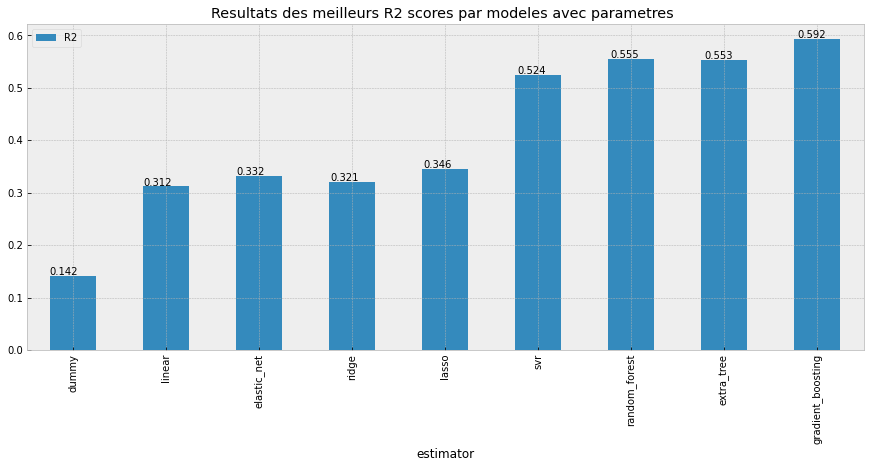

In [14]:
algo_estimator.getBestModeleScore_graphR2()

In [15]:
algo_estimator.getBestModeleScore_summary(useIndex=True,showR2=True)

R2     MAE    RMSE
estimator                               
dummy              0.142  57.192  97.631
linear             0.312  38.456  76.179
elastic_net        0.332  39.653  74.925
ridge              0.321  39.834  75.703
lasso              0.346  39.263  73.966
svr                0.524  33.646  63.229
random_forest      0.555  32.692  61.024
extra_tree         0.553  32.428  61.239
gradient_boosting  0.592  31.383  58.436

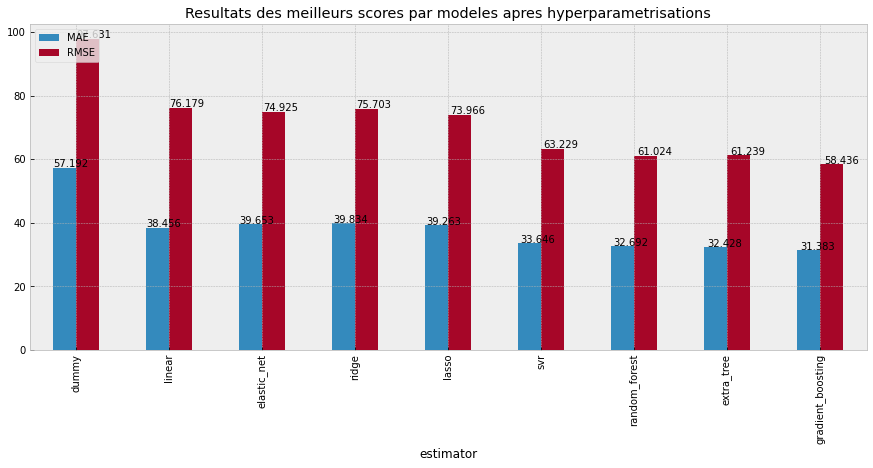

In [16]:
algo_estimator.getBestModeleScore_graph()

## resultat des meilleurs scores par predictions

Maintenand que notre entrainement est terminer , nous pouvons etudier nos resultats par modeles.

Recapitulons nous avons un ensemble de features que nous avons entrainer en fonction de notre variable cible a partir des metriques mae et rmse , l a metrique r2 est ici a titre indicatif

In [17]:
algo_estimator.getBestModeleScore_summary(useIndex=True,showR2=True).compare(algo_estimatorDefaults.getBestModeleScore_summary(showR2=True), align_axis=0).rename(index={'self': 'with options', 'other': 'default'})

R2     MAE    RMSE
estimator                                            
dummy             with options  0.142  57.192  97.631
                  default       0.147  57.158  97.847
elastic_net       with options  0.332  39.653  74.925
                  default       0.118  56.000  96.561
ridge             with options  0.321  39.834  75.703
                  default       0.299  38.723  76.859
lasso             with options  0.346  39.263  73.966
                  default       0.147  57.158  97.847
svr               with options  0.524  33.646  63.229
                  default       0.507  34.307  64.353
random_forest     with options  0.555  32.692  61.024
                  default       0.550  33.056  61.249
extra_tree        with options  0.553  32.428  61.239
                  default       0.544  32.789  61.861
gradient_boosting with options  0.592  31.383  58.436
                  default       0.589  31.622  58.672

In [18]:
withParam = algo_estimator.getBestModeleScore_scorePrediction(True, showR2=True)
withoutparam = algo_estimatorDefaults.getBestModeleScore_scorePrediction(True, showR2=True)

L ajout de nos hyperparametres a ameliorer nos resultats par rapport aux modeles par default

Le modele gradiant boosting a a peu pres les memes resultats avec ou sans hyperparametres

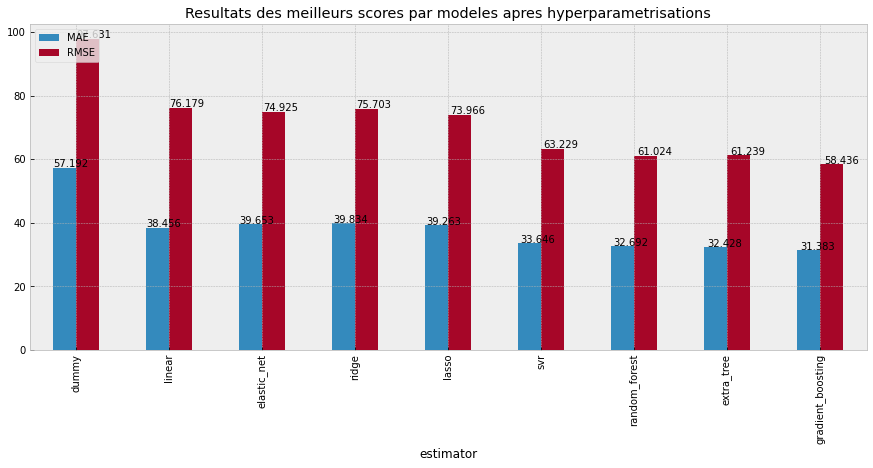

In [19]:
algo_estimator.getBestModeleScore_graph()

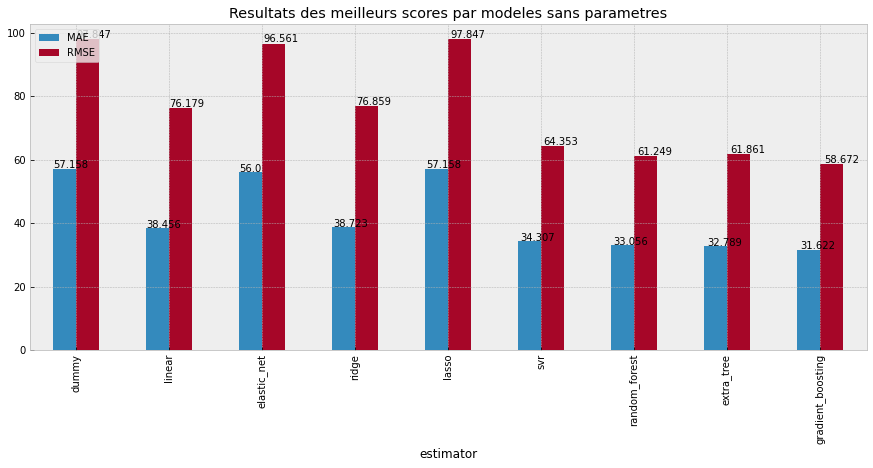

In [20]:
algo_estimatorDefaults.getBestModeleScore_graph()

<a name='cu'></a>
# comparaisons des predictions par defaults et custom

Maintenant comparons les scores des predictions par modeles avec ou sans hyper parametres

In [21]:
algo_estimator.getBestModeleScore_scorePrediction(useIndex=True, showR2=True).compare(algo_estimatorDefaults.getBestModeleScore_scorePrediction(True, showR2=True), align_axis=0).rename(index={'self': 'with options', 'other': 'default'})

R2     MAE     RMSE
estimator                                               
dummy             with options -0.11684  52.130   85.501
                  default      -0.12229  52.105   85.709
elastic_net       with options -0.27416  40.437   91.325
                  default      -0.08350  50.818   84.216
ridge             with options -3.73979  47.567  176.139
                  default      -8.47365  52.953  249.021
lasso             with options -0.14196  38.926   86.457
                  default      -0.12229  52.105   85.709
svr               with options  0.63124  28.203   49.130
                  default       0.57506  30.697   52.740
random_forest     with options  0.63037  26.328   49.188
                  default       0.64600  26.268   48.137
extra_tree        with options  0.60244  26.886   51.013
                  default       0.60638  27.082   50.759
gradient_boosting with options  0.67011  26.247   46.469
                  default       0.67617  26.102   46.040

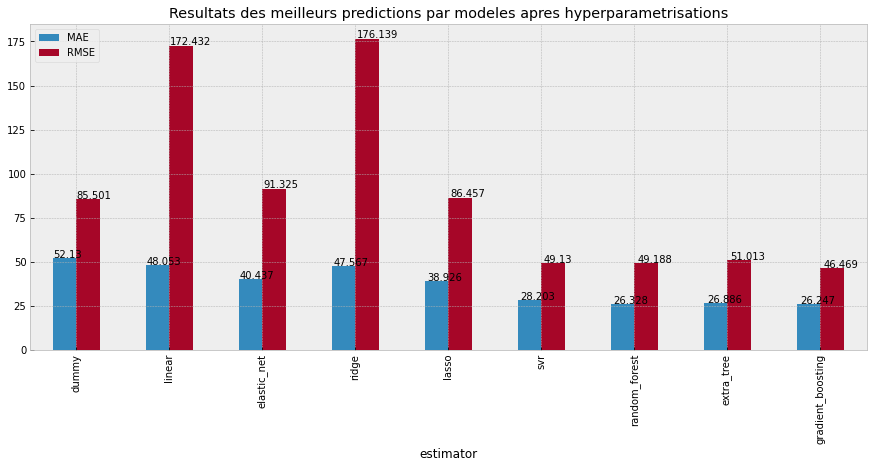

In [22]:
algo_estimator.getBestModeleScore_graphpredictions()

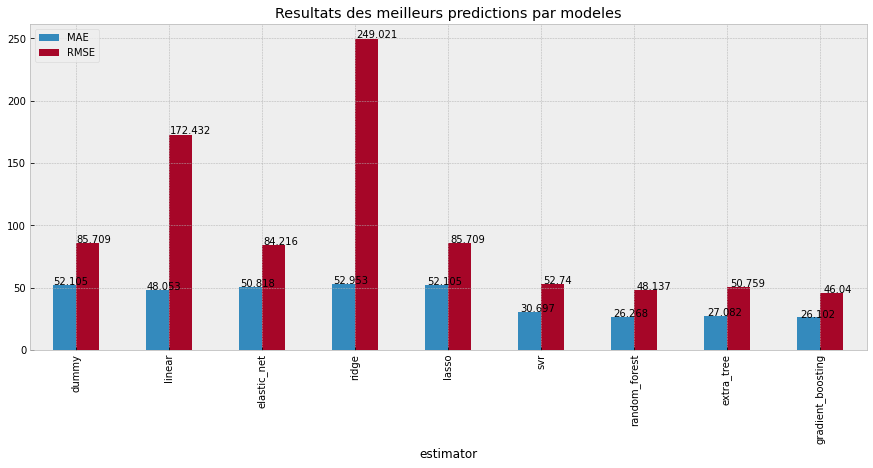

In [23]:
algo_estimatorDefaults.getBestModeleScore_graphpredictions()

Grace a nos hyperparametres nous avons ameliores globalement nos modeles

**Meilleurs parametres pour chaque modeles**

In [24]:
algo_estimator.showBestParams()

estimator  \
0              dummy   
1             linear   
2        elastic_net   
3              ridge   
4              lasso   
5                svr   
6      random_forest   
7         extra_tree   
8  gradient_boosting   

                                                                                                                                                                best_params  
0                                                                                                                                  {'dummy__regressor__strategy': 'median'}  
1                                                                                             {'linear__regressor__copy_X': True, 'linear__regressor__fit_intercept': True}  
2  {'elastic_net__regressor__alpha': 0.1, 'elastic_net__regressor__l1_ratio': 0.4, 'elastic_net__regressor__max_iter': 3000, 'elastic_net__regressor__selection': 'random'}  
3                                                                                        {'ridge__regressor__alpha': 236.4489412645407, 'ridge__regressor__max_iter': 1000}  
4                                                                                      {'lasso__regressor__alpha': 0.04328761281083057, 'lasso__regressor__max_iter': 1000}  
5                                                {'svr__regressor__C': 3, 'svr__regressor__epsilon': 0.3, 'svr__regressor__gamma': 'auto', 'svr__regressor__kernel': 'rbf'}  
6                                                                         {'random_forest__regressor__max_features': 'auto', 'random_forest__regressor__n_estimators': 100}  
7                                    {'extra_tree__regressor__bootstrap': False, 'extra_tree__regressor__min_samples_split': 4, 'extra_tree__regressor__n_estimators': 100}  
8             {'gradient_boosting__regressor__learning_rate': 0.01, 'gradient_boosting__regressor__max_leaf_nodes': 50, 'gradient_boosting__regressor__n_estimators': 1000}

# optimisation de linear regression

In [25]:
sorted(algo_estimator.grid_searches['linear'].get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__linear',
 'estimator__linear__check_inverse',
 'estimator__linear__func',
 'estimator__linear__inverse_func',
 'estimator__linear__regressor',
 'estimator__linear__regressor__copy_X',
 'estimator__linear__regressor__fit_intercept',
 'estimator__linear__regressor__n_jobs',
 'estimator__linear__regressor__normalize',
 'estimator__linear__regressor__positive',
 'estimator__linear__transformer',
 'estimator__memory',
 'estimator__preprocessor',
 'estimator__preprocessor__boolean',
 'estimator__preprocessor__boolean__memory',
 'estimator__preprocessor__boolean__otherEnergy',
 'estimator__preprocessor__boolean__otherEnergy__accept_sparse',
 'estimator__preprocessor__boolean__otherEnergy__check_inverse',
 'estimator__preprocessor__boolean__otherEnergy__func',
 'estimator__preprocessor__boolean__otherEnergy__inv_kw_args',
 'estimator__preprocessor__boolean__otherEnergy__inverse_func',
 'estimator__preprocessor__boolean__otherEnergy__kw_args',
 

estimator  \
1    linear   

                                                                     best_params  
1  {'linear__regressor__copy_X': True, 'linear__regressor__fit_intercept': True}

estimator     R2     MAE    RMSE
1    linear  0.312  38.456  76.179

estimator       R2     MAE     RMSE
1    linear -3.54234  48.053  172.432

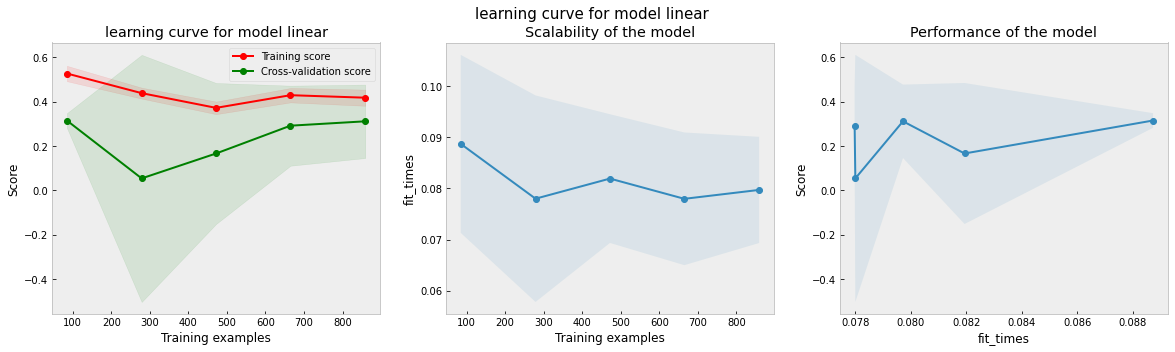

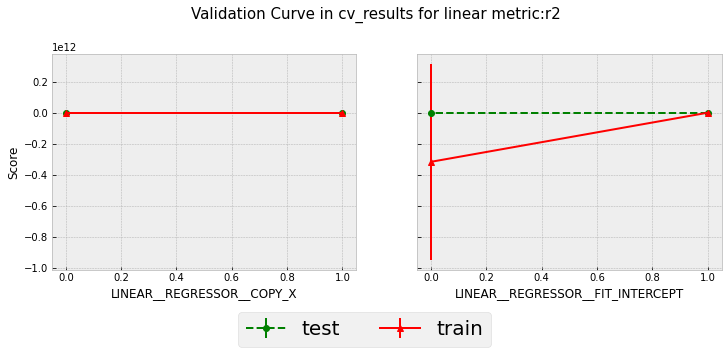

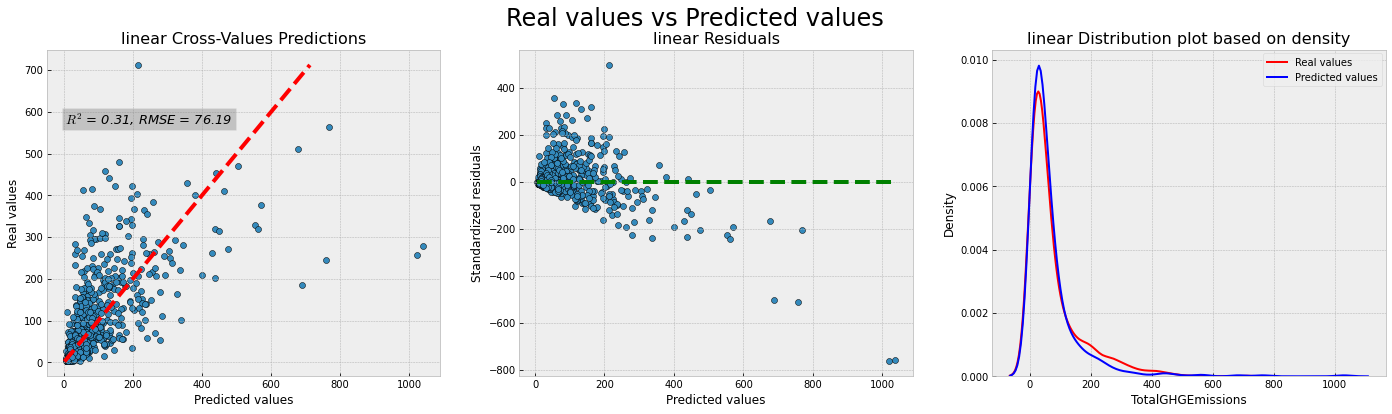

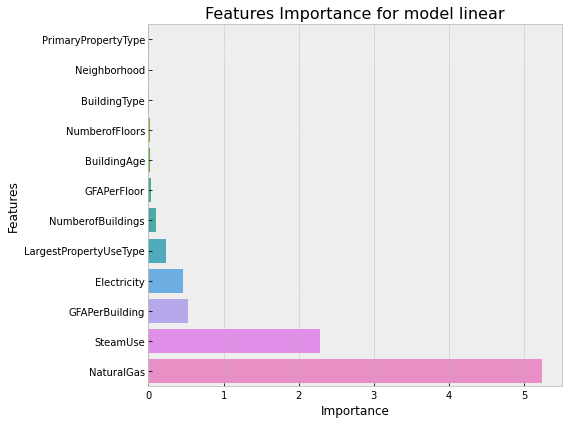

In [26]:
modele_name = 'linear'
algo_estimator.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True)

In [27]:
sorted(algo_estimator.grid_searches['dummy'].get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__dummy',
 'estimator__dummy__check_inverse',
 'estimator__dummy__func',
 'estimator__dummy__inverse_func',
 'estimator__dummy__regressor',
 'estimator__dummy__regressor__constant',
 'estimator__dummy__regressor__quantile',
 'estimator__dummy__regressor__strategy',
 'estimator__dummy__transformer',
 'estimator__memory',
 'estimator__preprocessor',
 'estimator__preprocessor__boolean',
 'estimator__preprocessor__boolean__memory',
 'estimator__preprocessor__boolean__otherEnergy',
 'estimator__preprocessor__boolean__otherEnergy__accept_sparse',
 'estimator__preprocessor__boolean__otherEnergy__check_inverse',
 'estimator__preprocessor__boolean__otherEnergy__func',
 'estimator__preprocessor__boolean__otherEnergy__inv_kw_args',
 'estimator__preprocessor__boolean__otherEnergy__inverse_func',
 'estimator__preprocessor__boolean__otherEnergy__kw_args',
 'estimator__preprocessor__boolean__otherEnergy__validate',
 'estimator__preprocessor__boolean__st

Le modele Dummy sera pris comme baseline de comparaisons

estimator                               best_params
0     dummy  {'dummy__regressor__strategy': 'median'}

estimator     R2     MAE    RMSE
0     dummy  0.142  57.192  97.631

estimator       R2    MAE    RMSE
0     dummy -0.11684  52.13  85.501

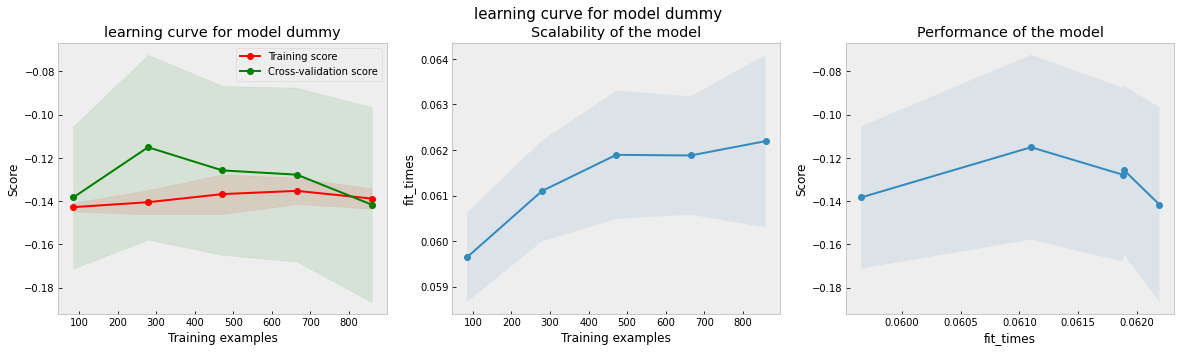

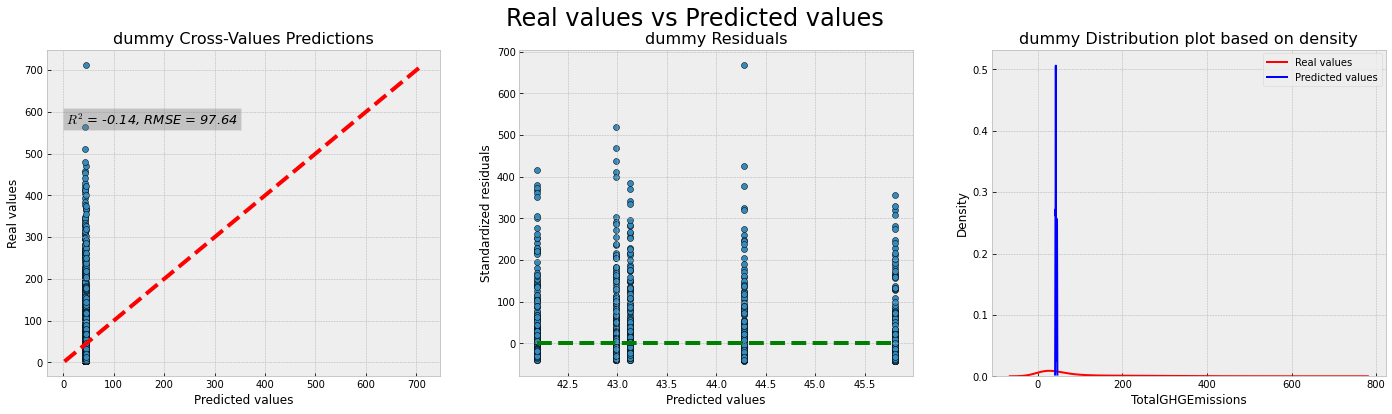

In [28]:
modele_name = 'dummy'
algo_estimator.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=False,showLasso=False,showFeaturesImportances=False)

In [29]:
sorted(algo_estimator.grid_searches['ridge'].get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__memory',
 'estimator__preprocessor',
 'estimator__preprocessor__boolean',
 'estimator__preprocessor__boolean__memory',
 'estimator__preprocessor__boolean__otherEnergy',
 'estimator__preprocessor__boolean__otherEnergy__accept_sparse',
 'estimator__preprocessor__boolean__otherEnergy__check_inverse',
 'estimator__preprocessor__boolean__otherEnergy__func',
 'estimator__preprocessor__boolean__otherEnergy__inv_kw_args',
 'estimator__preprocessor__boolean__otherEnergy__inverse_func',
 'estimator__preprocessor__boolean__otherEnergy__kw_args',
 'estimator__preprocessor__boolean__otherEnergy__validate',
 'estimator__preprocessor__boolean__steps',
 'estimator__preprocessor__boolean__verbose',
 'estimator__preprocessor__categorical',
 'estimator__preprocessor__categorical__memory',
 'estimator__preprocessor__categorical__rob_scaler',
 'estimator__preprocessor__categorical__rob_scaler__copy',
 'estimator__preprocessor__categorical__rob_scaler__quant

# Régularisation

La procédure de régularisation a pour but d'éviter que le modèle ne surapprenne (en anglais overfit) les données et ainsi vise à régler les problèmes de grande variance


le modele ridge rend les coefficients plus petits

<img alt="Ridge" width='200' height='200' class="img-responsive" src="https://stanford.edu/~shervine/teaching/cs-229/illustrations/ridge.png?77abafe4253433af93fb8ffc7d4f6bc7">

estimator  \
3     ridge   

                                                                          best_params  
3  {'ridge__regressor__alpha': 236.4489412645407, 'ridge__regressor__max_iter': 1000}

estimator     R2     MAE    RMSE
3     ridge  0.321  39.834  75.703

estimator       R2     MAE     RMSE
3     ridge -3.73979  47.567  176.139

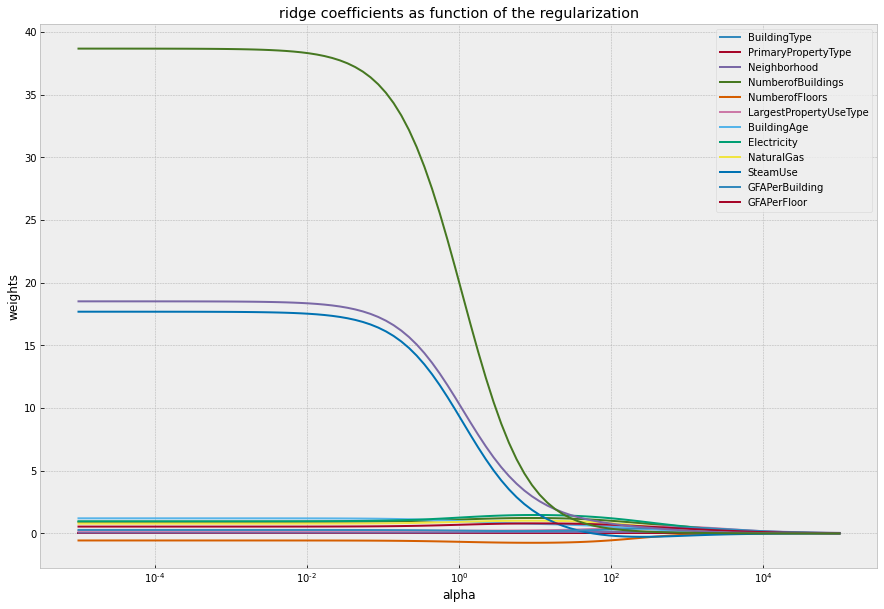

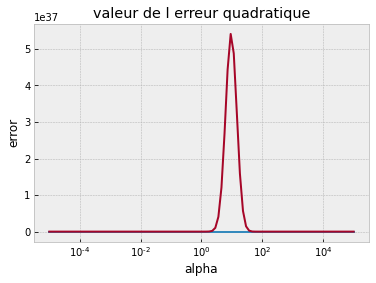

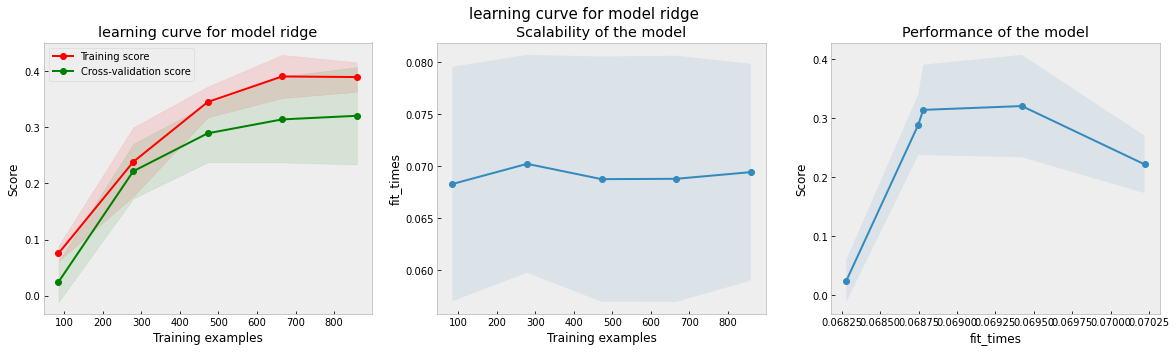

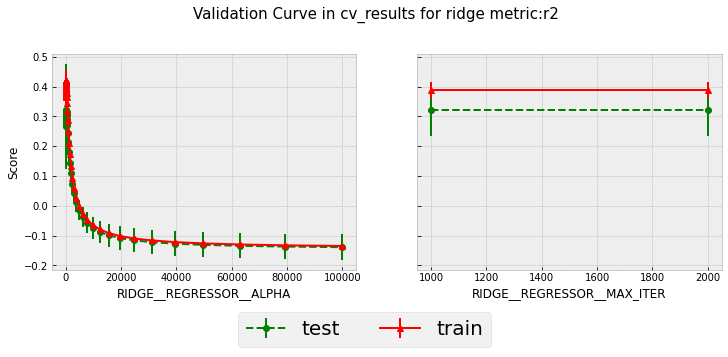

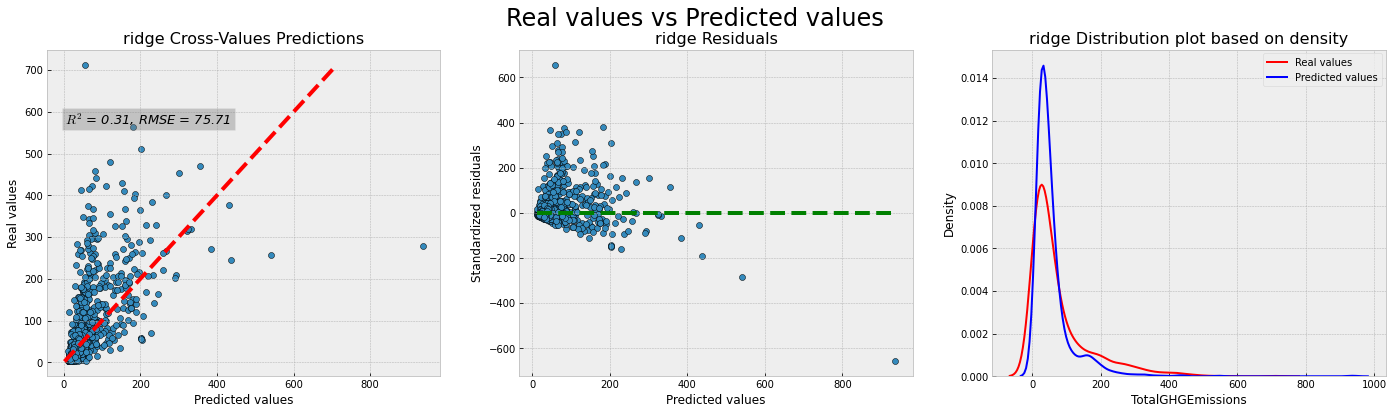

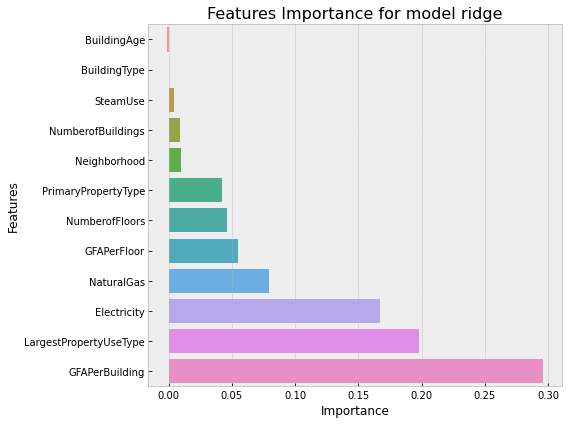

In [30]:
modele_name = 'ridge'
algo_estimator.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=True,showFeaturesImportances=True)

In [31]:
sorted(algo_estimator.grid_searches['lasso'].get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__lasso',
 'estimator__lasso__check_inverse',
 'estimator__lasso__func',
 'estimator__lasso__inverse_func',
 'estimator__lasso__regressor',
 'estimator__lasso__regressor__alpha',
 'estimator__lasso__regressor__copy_X',
 'estimator__lasso__regressor__fit_intercept',
 'estimator__lasso__regressor__max_iter',
 'estimator__lasso__regressor__normalize',
 'estimator__lasso__regressor__positive',
 'estimator__lasso__regressor__precompute',
 'estimator__lasso__regressor__random_state',
 'estimator__lasso__regressor__selection',
 'estimator__lasso__regressor__tol',
 'estimator__lasso__regressor__warm_start',
 'estimator__lasso__transformer',
 'estimator__memory',
 'estimator__preprocessor',
 'estimator__preprocessor__boolean',
 'estimator__preprocessor__boolean__memory',
 'estimator__preprocessor__boolean__otherEnergy',
 'estimator__preprocessor__boolean__otherEnergy__accept_sparse',
 'estimator__preprocessor__boolean__otherEnergy__check_inverse',

le modele Lasso

• Réduit les coefficients à 0

• Bon pour la sélection de variables

<img alt="Ridge" width='200' height='200' class="img-responsive" src="https://stanford.edu/~shervine/teaching/cs-229/illustrations/lasso.png?ad67282f00fc8b2a529e5b15a856f91b">

estimator  \
4     lasso   

                                                                            best_params  
4  {'lasso__regressor__alpha': 0.04328761281083057, 'lasso__regressor__max_iter': 1000}

estimator     R2     MAE    RMSE
4     lasso  0.346  39.263  73.966

estimator       R2     MAE    RMSE
4     lasso -0.14196  38.926  86.457

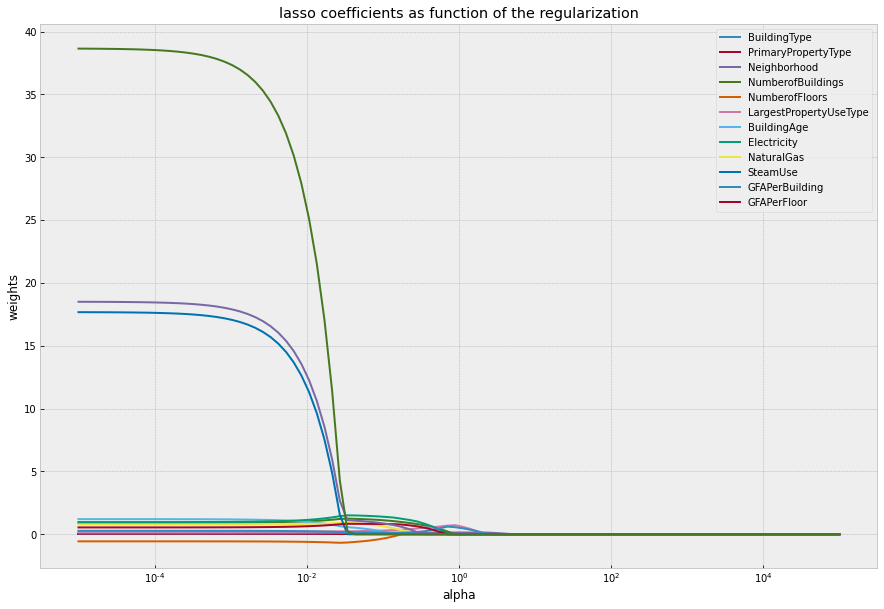

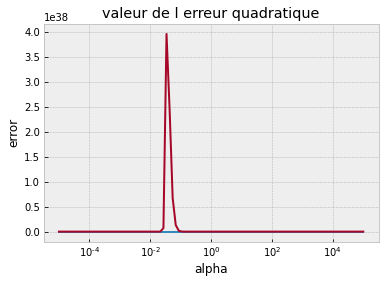

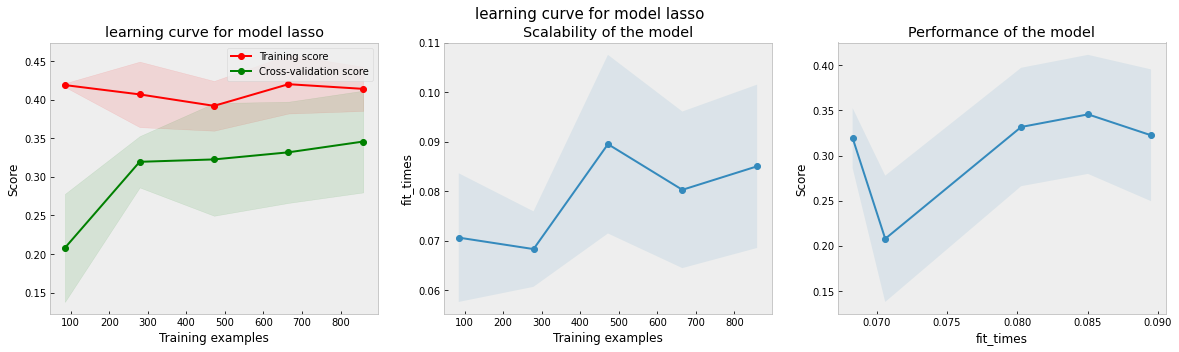

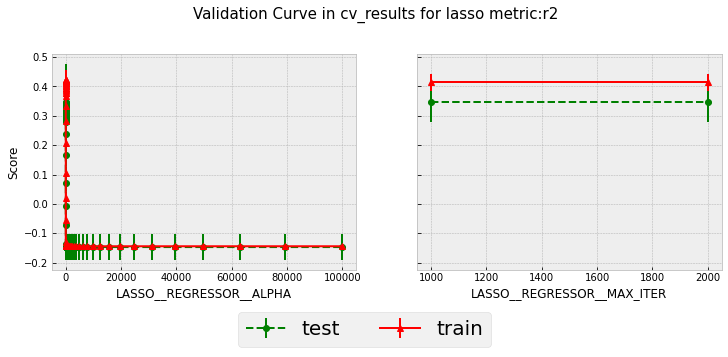

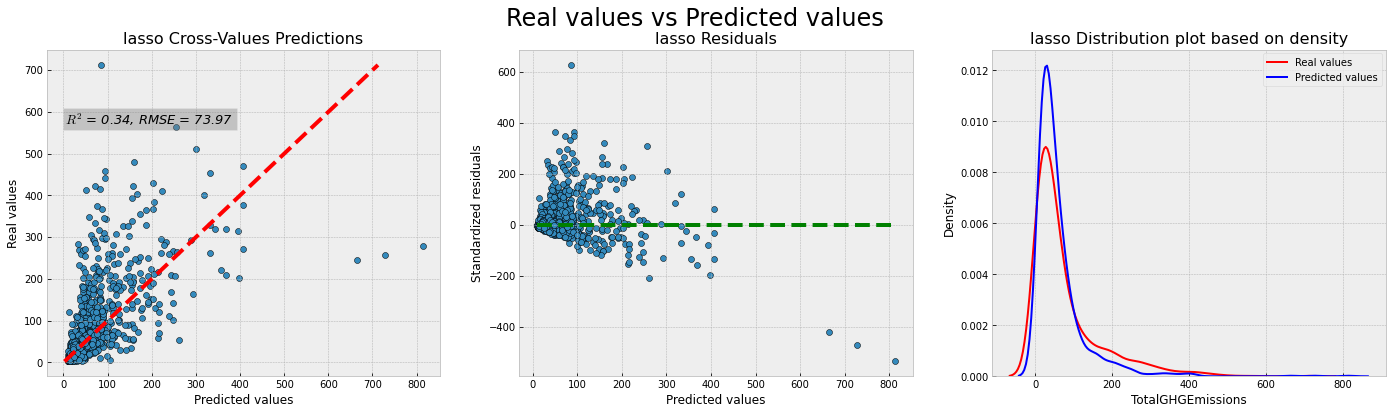

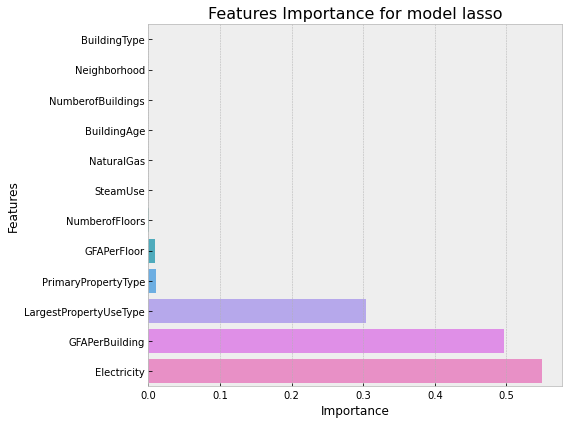

In [32]:
modele_name = 'lasso'
algo_estimator.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=True,showFeaturesImportances=True)

In [33]:
sorted(algo_estimator.grid_searches['elastic_net'].get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__elastic_net',
 'estimator__elastic_net__check_inverse',
 'estimator__elastic_net__func',
 'estimator__elastic_net__inverse_func',
 'estimator__elastic_net__regressor',
 'estimator__elastic_net__regressor__alpha',
 'estimator__elastic_net__regressor__copy_X',
 'estimator__elastic_net__regressor__fit_intercept',
 'estimator__elastic_net__regressor__l1_ratio',
 'estimator__elastic_net__regressor__max_iter',
 'estimator__elastic_net__regressor__normalize',
 'estimator__elastic_net__regressor__positive',
 'estimator__elastic_net__regressor__precompute',
 'estimator__elastic_net__regressor__random_state',
 'estimator__elastic_net__regressor__selection',
 'estimator__elastic_net__regressor__tol',
 'estimator__elastic_net__regressor__warm_start',
 'estimator__elastic_net__transformer',
 'estimator__memory',
 'estimator__preprocessor',
 'estimator__preprocessor__boolean',
 'estimator__preprocessor__boolean__memory',
 'estimator__preprocessor__bo

le modele Lasso elastic_net fait un compromis entre la sélection de variables et la réduction de coefficients

<img alt="Ridge" width='200' height='200' class="img-responsive" src="https://stanford.edu/~shervine/teaching/cs-229/illustrations/elastic-net.png?8cd93eb9df1b6ae667d8eb69d20bf4a1">

estimator  \
2  elastic_net   

                                                                                                                                                                best_params  
2  {'elastic_net__regressor__alpha': 0.1, 'elastic_net__regressor__l1_ratio': 0.4, 'elastic_net__regressor__max_iter': 3000, 'elastic_net__regressor__selection': 'random'}

estimator     R2     MAE    RMSE
2  elastic_net  0.332  39.653  74.925

estimator       R2     MAE    RMSE
2  elastic_net -0.27416  40.437  91.325

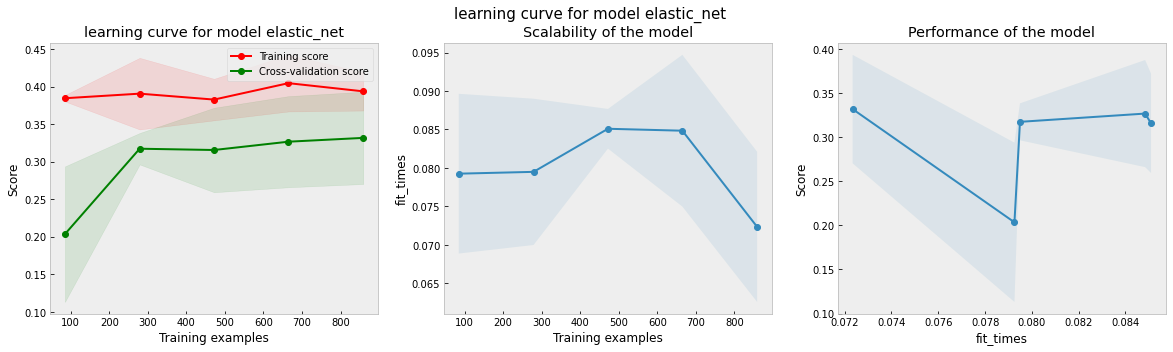

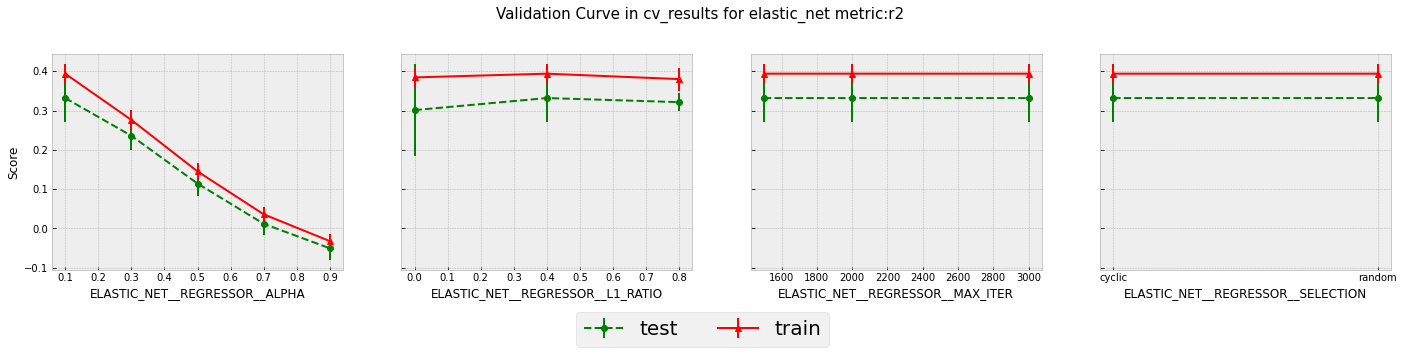

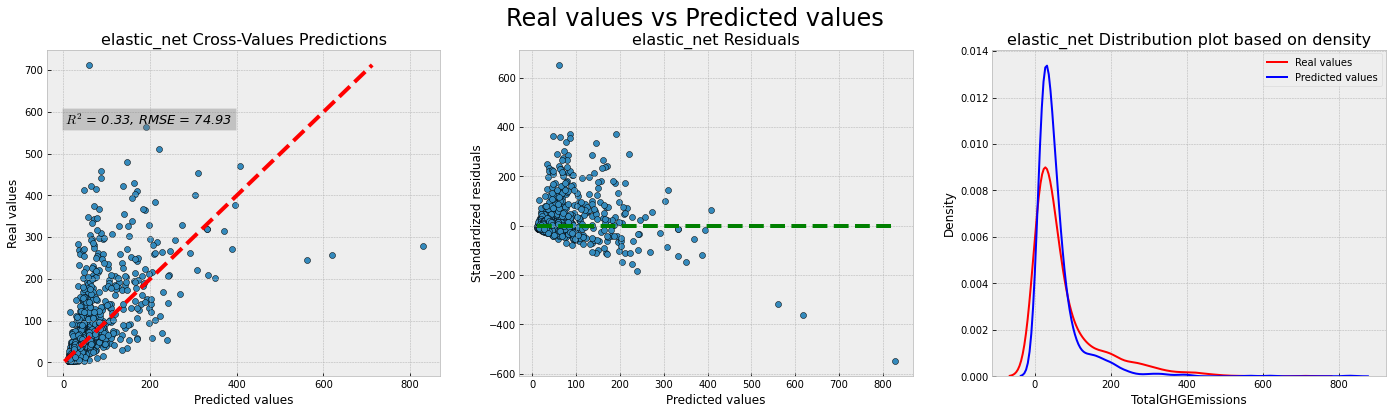

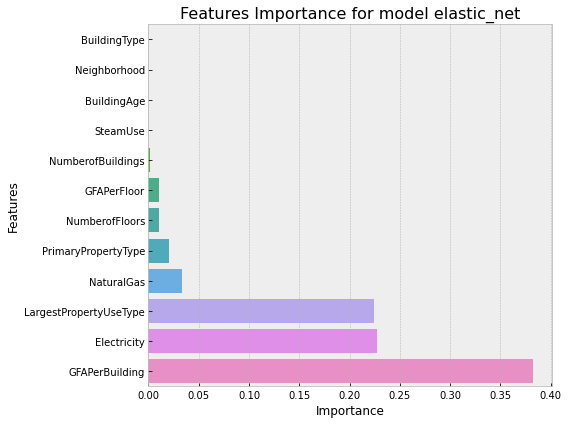

In [34]:
modele_name = 'elastic_net'
algo_estimator.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True)

In [35]:
sorted(algo_estimator.grid_searches['svr'].get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__memory',
 'estimator__preprocessor',
 'estimator__preprocessor__boolean',
 'estimator__preprocessor__boolean__memory',
 'estimator__preprocessor__boolean__otherEnergy',
 'estimator__preprocessor__boolean__otherEnergy__accept_sparse',
 'estimator__preprocessor__boolean__otherEnergy__check_inverse',
 'estimator__preprocessor__boolean__otherEnergy__func',
 'estimator__preprocessor__boolean__otherEnergy__inv_kw_args',
 'estimator__preprocessor__boolean__otherEnergy__inverse_func',
 'estimator__preprocessor__boolean__otherEnergy__kw_args',
 'estimator__preprocessor__boolean__otherEnergy__validate',
 'estimator__preprocessor__boolean__steps',
 'estimator__preprocessor__boolean__verbose',
 'estimator__preprocessor__categorical',
 'estimator__preprocessor__categorical__memory',
 'estimator__preprocessor__categorical__rob_scaler',
 'estimator__preprocessor__categorical__rob_scaler__copy',
 'estimator__preprocessor__categorical__rob_scaler__quant

Le SVR (Support Vector Regression) est une régression vectorielle de type Epsilon-support et est implémenté au niveau de libsvm.

estimator  \
5       svr   

                                                                                                                  best_params  
5  {'svr__regressor__C': 3, 'svr__regressor__epsilon': 0.3, 'svr__regressor__gamma': 'auto', 'svr__regressor__kernel': 'rbf'}

estimator     R2     MAE    RMSE
5       svr  0.524  33.646  63.229

estimator       R2     MAE   RMSE
5       svr  0.63124  28.203  49.13

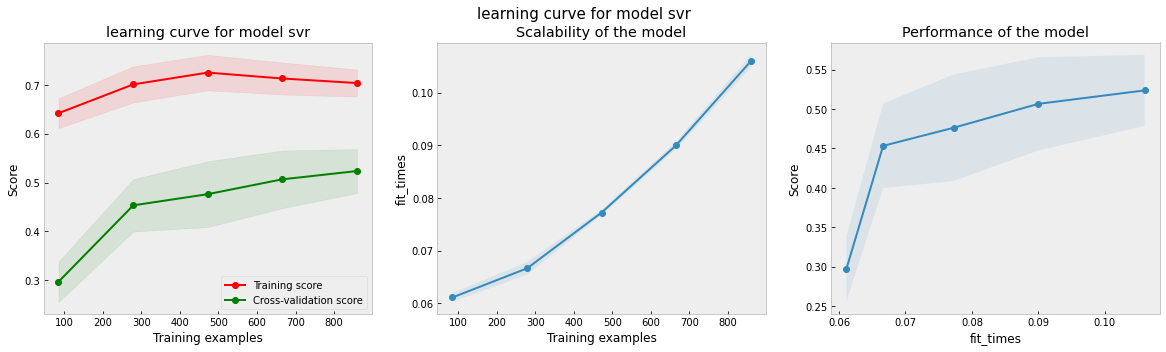

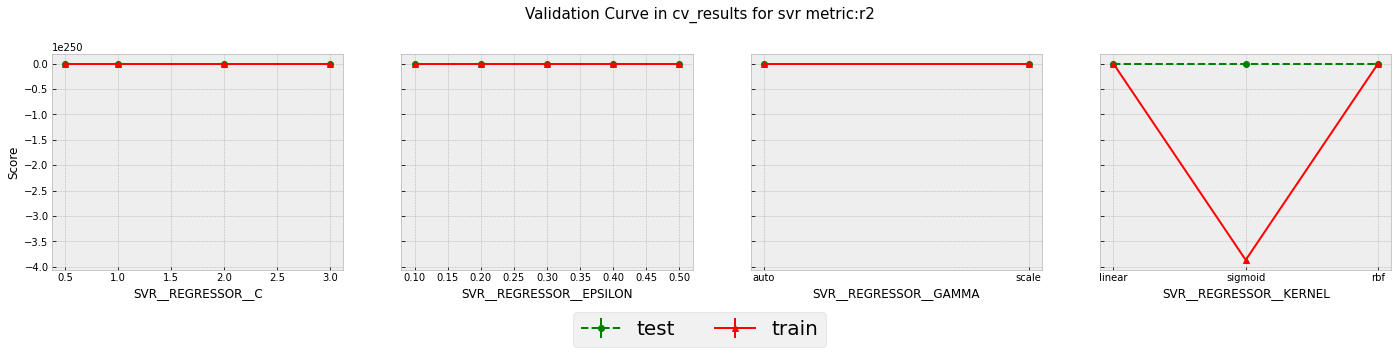

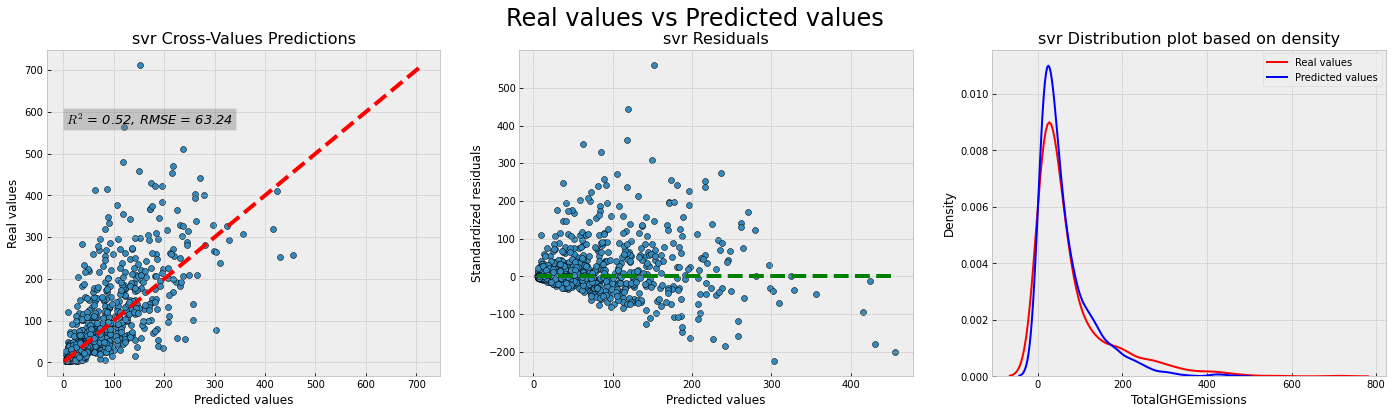

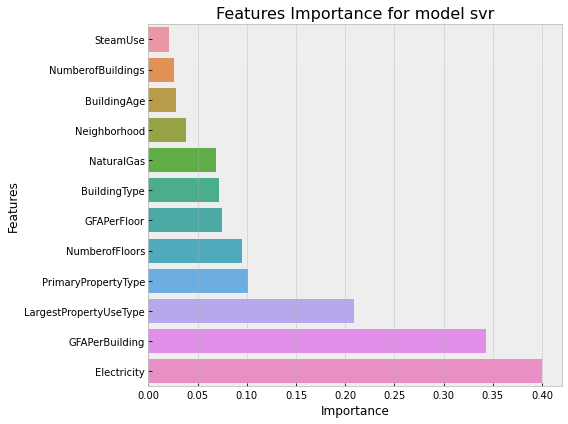

In [36]:
modele_name = 'svr'
algo_estimator.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True)

**Random Forest** : C'est une technique à base d'arbres qui utilise un très grand nombre d'arbres de décisions construits à partir d'ensembles de caractéristiques aléatoirement sélectionnés. Contrairement à un simple arbre de décision, il n'est pas interprétable du tout mais le fait qu'il ait une bonne performance en fait un algorithme populaire.

In [37]:
sorted(algo_estimator.grid_searches['random_forest'].get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__memory',
 'estimator__preprocessor',
 'estimator__preprocessor__boolean',
 'estimator__preprocessor__boolean__memory',
 'estimator__preprocessor__boolean__otherEnergy',
 'estimator__preprocessor__boolean__otherEnergy__accept_sparse',
 'estimator__preprocessor__boolean__otherEnergy__check_inverse',
 'estimator__preprocessor__boolean__otherEnergy__func',
 'estimator__preprocessor__boolean__otherEnergy__inv_kw_args',
 'estimator__preprocessor__boolean__otherEnergy__inverse_func',
 'estimator__preprocessor__boolean__otherEnergy__kw_args',
 'estimator__preprocessor__boolean__otherEnergy__validate',
 'estimator__preprocessor__boolean__steps',
 'estimator__preprocessor__boolean__verbose',
 'estimator__preprocessor__categorical',
 'estimator__preprocessor__categorical__memory',
 'estimator__preprocessor__categorical__rob_scaler',
 'estimator__preprocessor__categorical__rob_scaler__copy',
 'estimator__preprocessor__categorical__rob_scaler__quant

estimator  \
6  random_forest   

                                                                                         best_params  
6  {'random_forest__regressor__max_features': 'auto', 'random_forest__regressor__n_estimators': 100}

estimator     R2     MAE    RMSE
6  random_forest  0.555  32.692  61.024

estimator       R2     MAE    RMSE
6  random_forest  0.63037  26.328  49.188

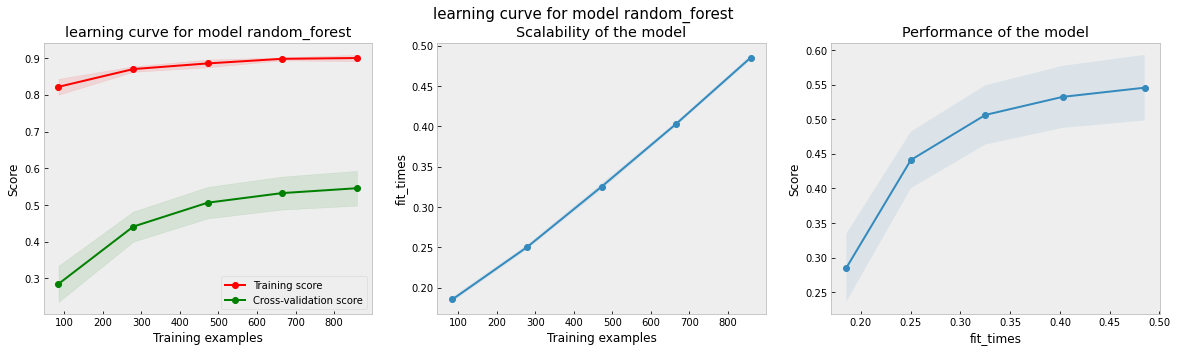

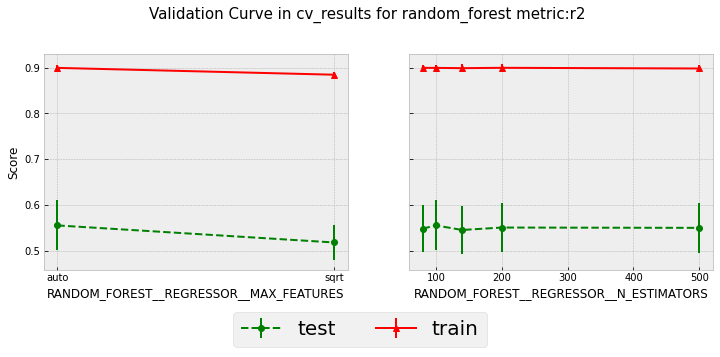

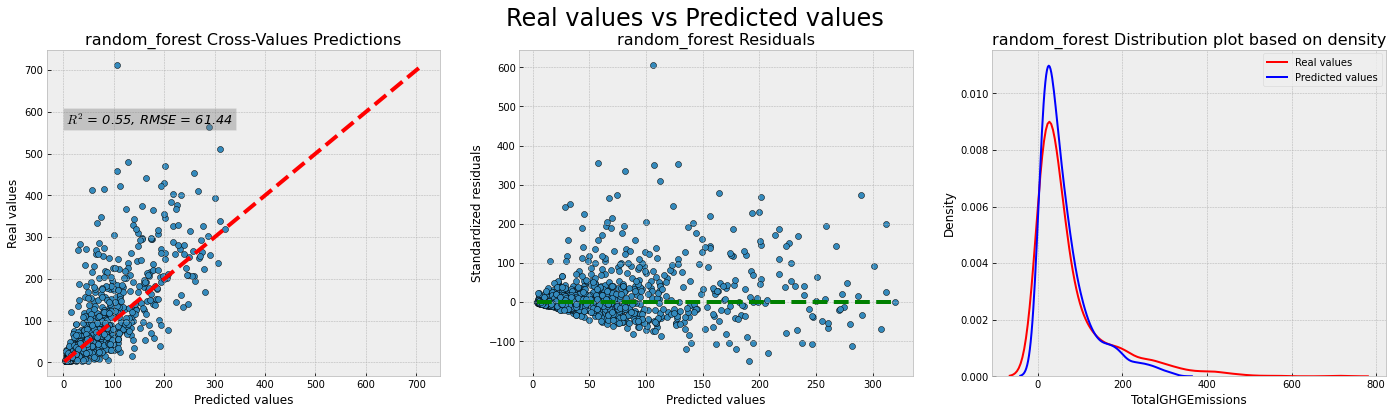

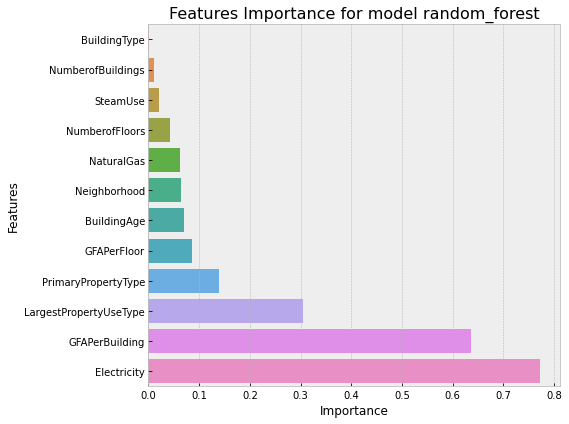

In [38]:
modele_name = 'random_forest'
algo_estimator.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True)

In [39]:
sorted(algo_estimator.grid_searches['extra_tree'].get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__extra_tree',
 'estimator__extra_tree__check_inverse',
 'estimator__extra_tree__func',
 'estimator__extra_tree__inverse_func',
 'estimator__extra_tree__regressor',
 'estimator__extra_tree__regressor__bootstrap',
 'estimator__extra_tree__regressor__ccp_alpha',
 'estimator__extra_tree__regressor__criterion',
 'estimator__extra_tree__regressor__max_depth',
 'estimator__extra_tree__regressor__max_features',
 'estimator__extra_tree__regressor__max_leaf_nodes',
 'estimator__extra_tree__regressor__max_samples',
 'estimator__extra_tree__regressor__min_impurity_decrease',
 'estimator__extra_tree__regressor__min_samples_leaf',
 'estimator__extra_tree__regressor__min_samples_split',
 'estimator__extra_tree__regressor__min_weight_fraction_leaf',
 'estimator__extra_tree__regressor__n_estimators',
 'estimator__extra_tree__regressor__n_jobs',
 'estimator__extra_tree__regressor__oob_score',
 'estimator__extra_tree__regressor__random_state',
 'estimator_

Extra_tree implémente un méta-estimateur qui ajuste un certain nombre d'arbres de décision aléatoires (alias extra-arbres)sur divers sous-échantillons de l'ensemble de données et utilise la moyenne pour améliorer la précision prédictive et contrôler le sur-ajustement.

estimator  \
7  extra_tree   

                                                                                                                              best_params  
7  {'extra_tree__regressor__bootstrap': False, 'extra_tree__regressor__min_samples_split': 4, 'extra_tree__regressor__n_estimators': 100}

estimator     R2     MAE    RMSE
7  extra_tree  0.553  32.428  61.239

estimator       R2     MAE    RMSE
7  extra_tree  0.60244  26.886  51.013

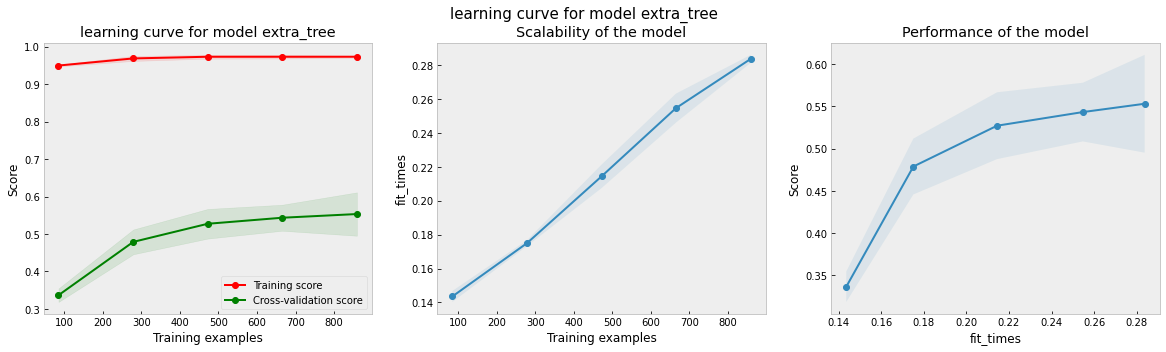

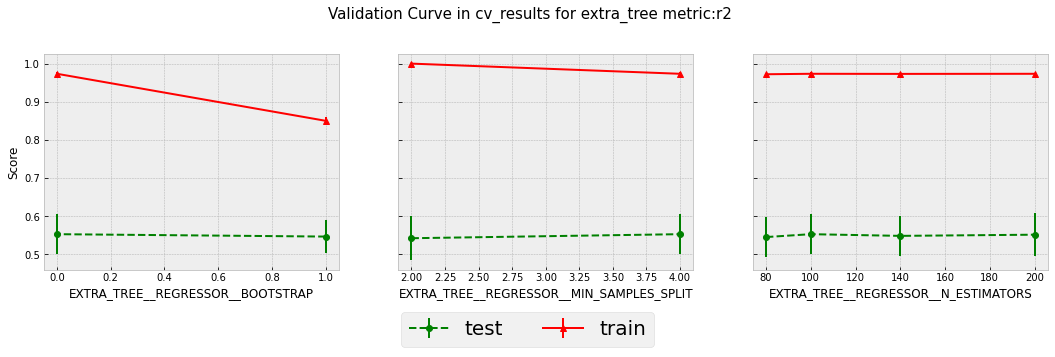

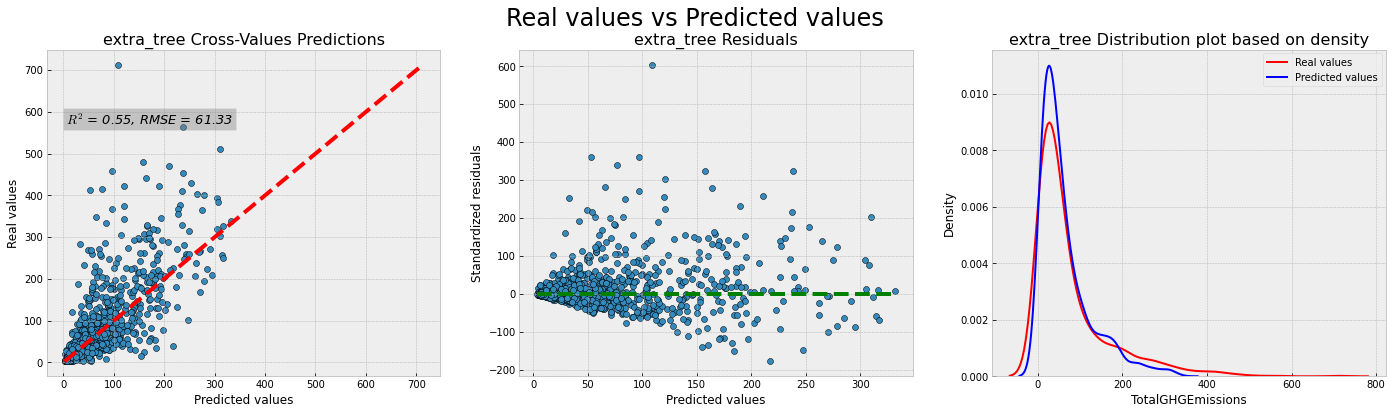

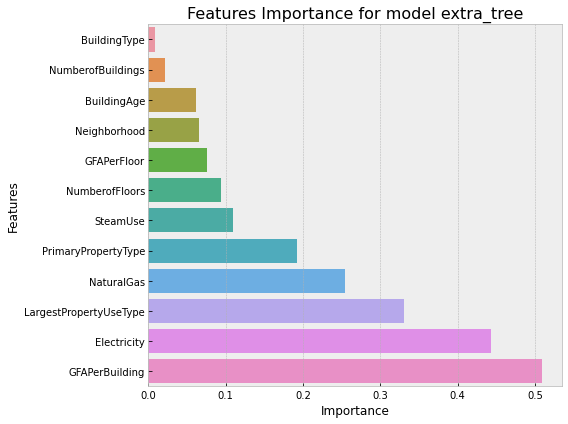

In [40]:
modele_name = 'extra_tree'
algo_estimator.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True)

In [41]:
sorted(algo_estimator.grid_searches['gradient_boosting'].get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__gradient_boosting',
 'estimator__gradient_boosting__check_inverse',
 'estimator__gradient_boosting__func',
 'estimator__gradient_boosting__inverse_func',
 'estimator__gradient_boosting__regressor',
 'estimator__gradient_boosting__regressor__alpha',
 'estimator__gradient_boosting__regressor__ccp_alpha',
 'estimator__gradient_boosting__regressor__criterion',
 'estimator__gradient_boosting__regressor__init',
 'estimator__gradient_boosting__regressor__learning_rate',
 'estimator__gradient_boosting__regressor__loss',
 'estimator__gradient_boosting__regressor__max_depth',
 'estimator__gradient_boosting__regressor__max_features',
 'estimator__gradient_boosting__regressor__max_leaf_nodes',
 'estimator__gradient_boosting__regressor__min_impurity_decrease',
 'estimator__gradient_boosting__regressor__min_samples_leaf',
 'estimator__gradient_boosting__regressor__min_samples_split',
 'estimator__gradient_boosting__regressor__min_weight_fraction_leaf

**Boosting** L'idée des méthodes de boosting est de combiner plusieurs modèles faibles pour former un modèle meilleur. Principe du  gradient boosting , Les modèles faibles sont entrainés sur les erreurs résiduelles

estimator  \
8  gradient_boosting   

                                                                                                                                                     best_params  
8  {'gradient_boosting__regressor__learning_rate': 0.01, 'gradient_boosting__regressor__max_leaf_nodes': 50, 'gradient_boosting__regressor__n_estimators': 1000}

estimator     R2     MAE    RMSE
8  gradient_boosting  0.592  31.383  58.436

estimator       R2     MAE    RMSE
8  gradient_boosting  0.67011  26.247  46.469

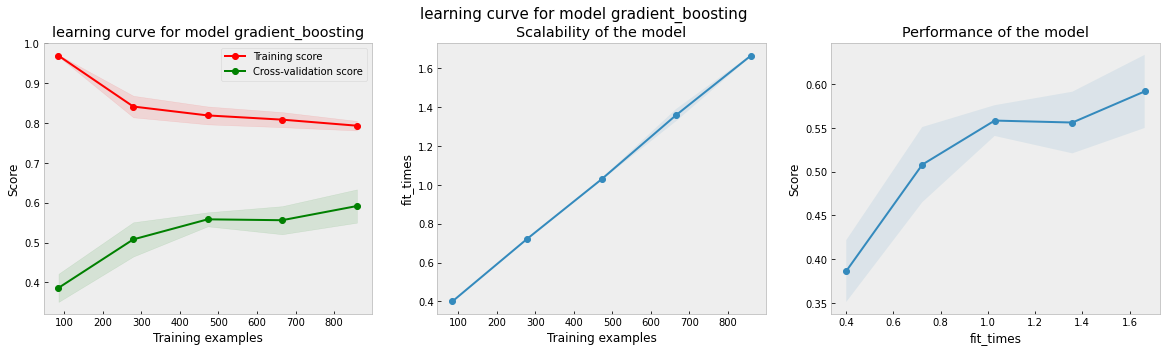

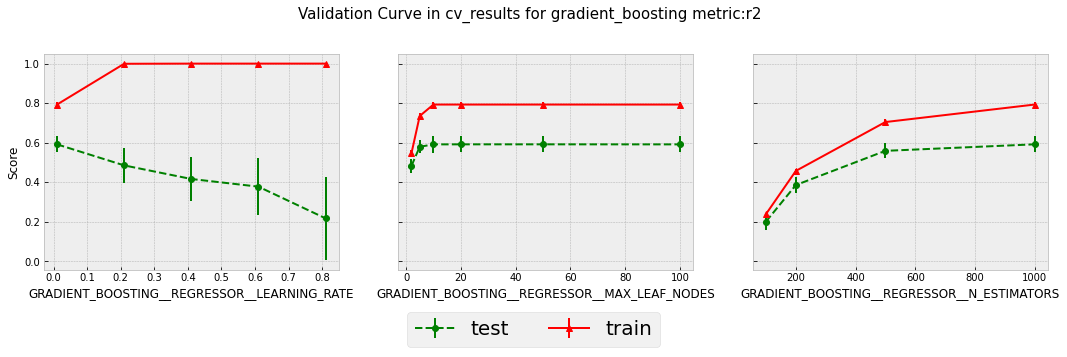

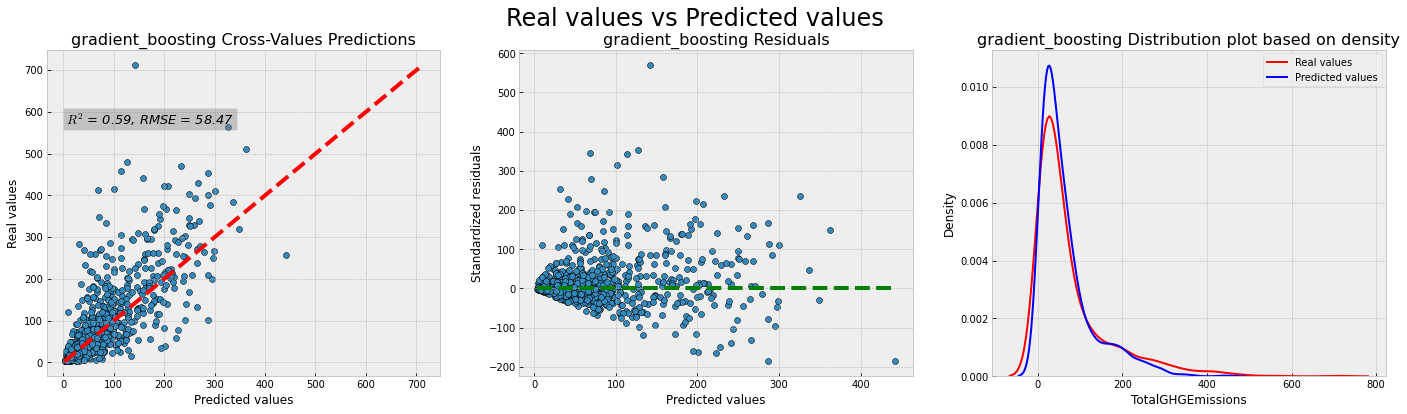

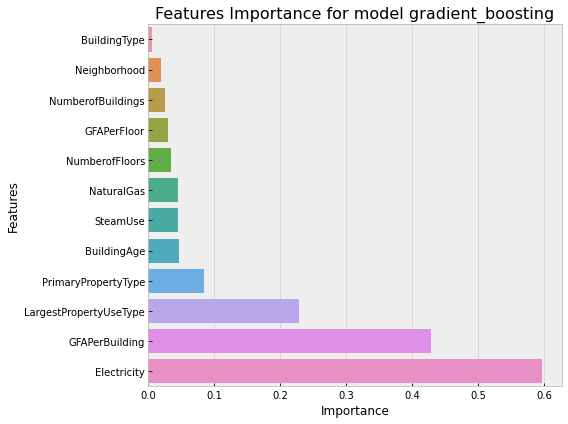

In [42]:
modele_name = 'gradient_boosting'
algo_estimator.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True)

<a name='en'></a>
# Test avec energystarScore


Nous allons realiser le meme apprentissage , mais cette fois avec l energy starScore, vu que cette variable n est pas bien rempli(70% environs), nous allons implementer un knn inputer sur cette variable, et l integrer dans la pipeline

In [43]:
seattle=pd.read_csv('seattle_cleaned.csv', sep=",") #3376 rows × 46 columns
seattle.shape
seattle = seattle.drop(['Unnamed: 0','DataYear'], axis=1)
#'DataYear', 'Latitude', 'Longitude'
seattle.shape

seattle = seattle.dropna(axis=0)
seattle.shape

(889, 19)

In [44]:
from sklearn.impute import KNNImputer

In [45]:
echantillon = seattle.copy()
echantillon = echantillon.drop(['Latitude','Longitude','GFABuildingRate','GFAParkingRate'], axis=1)


# numericColumns = ['NumberofBuildings', 'NumberofFloors',  'BuildingAge','Electricity', 'NaturalGas', 'SteamUse', 'GFAPerBuilding', 'GFAPerFloor', 'GFABuildingRate', 'GFAParkingRate','ENERGYSTARScore']
# numericColumns = ['NumberofBuildings', 'NumberofFloors',  'BuildingAge','Electricity', 'NaturalGas', 'SteamUse', 'GFAPerBuilding', 'GFAPerFloor']
# numericColumns = ['NumberofBuildings', 'NumberofFloors',  'BuildingAge','Electricity',   'GFAPerBuilding', 'GFAPerFloor']
numericColumns = ['NumberofBuildings', 'NumberofFloors',  'BuildingAge','Electricity',   'GFAPerBuilding', 'GFAPerFloor','NaturalGas', 'SteamUse']
qualitativesColumns = list(echantillon.select_dtypes(include=['object']))
#mettre une variable binaire a utiliser pour NaturalGas et SteamUse
booleanColumns = ['NaturalGas', 'SteamUse']
energyStart = ['ENERGYSTARScore']

X = echantillon.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)
# Y = echantillon[['SiteEnergyUse(kBtu)']]
Y = echantillon.loc[:,target_variable]

# Y = echantillon[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]

def boolean_transformation(X):
    return X.astype(int)


boolean_pipeline = Pipeline([
    ('otherEnergy',FunctionTransformer(boolean_transformation))
                            ])

energy_pipeline = Pipeline([
   ('knn', KNNImputer()), 
  ('rob_scaler', RobustScaler())  
])


# Labelize les variables catégorielles et les ajoute aux variables numériques transformés
categorical_pipeLine = Pipeline([
#     ('OneHotEncoder', OneHotEncoder(handle_unknown = 'ignore') ),
#     ('SVD',TruncatedSVD(n_components=5, n_iter=7, random_state=42))
    
    #meilleurs resultats avec ses parametres
    ('target', TargetEncoder()),    
    # ('std_scaler', StandardScaler()), # Normalisation des données  

     ('rob_scaler', RobustScaler())  
    
])

# Pipeline pour les variables numériques
numerical_pipeline = Pipeline([
    ('rob_scaler', RobustScaler()), # Normalisation des données
#     ('pca', decomposition.PCA())
])


preprocessor = ColumnTransformer([
        ("energy", energy_pipeline, energyStart),
        ("boolean",boolean_pipeline, booleanColumns),
        ("categorical", categorical_pipeLine, qualitativesColumns),    
        ("numeric", numerical_pipeline, numericColumns),                  
    ])


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],X_test.shape[0]))

Entrainement: 711 lignes,
Test: 178 lignes.



In [46]:
algo_estimatorDefaultsWithEnergy = EstimatorSelectionByAlgobyDefault(modeldefaults,True)
algo_estimatorDefaultsWithEnergy.fit(X_train,y_train)

Running GridSearchCV for dummy.
model DummyRegressor()
training dummy model done
elapsed time 1.53s
Running GridSearchCV for linear.
model LinearRegression()
training linear model done
elapsed time 0.84s
Running GridSearchCV for elastic_net.
model ElasticNet()
training elastic_net model done
elapsed time 0.92s
Running GridSearchCV for ridge.
model Ridge()
training ridge model done
elapsed time 0.90s
Running GridSearchCV for lasso.
model Lasso()
training lasso model done
elapsed time 0.91s
Running GridSearchCV for svr.
model SVR()
training svr model done
elapsed time 0.96s
Running GridSearchCV for random_forest.
model RandomForestRegressor()
training random_forest model done
elapsed time 1.57s
Running GridSearchCV for extra_tree.
model ExtraTreesRegressor()
training extra_tree model done
elapsed time 1.34s
Running GridSearchCV for gradient_boosting.
model GradientBoostingRegressor()
training gradient_boosting model done
elapsed time 0.57s
All training done.
total time 9.55s


Resultats R2 coefficient de determination

In [47]:
algo_estimatorDefaultsWithEnergy.getBestModeleScore_summary(showR2=True)

R2     MAE     RMSE
estimator                                  
dummy                0.154  57.392   95.496
linear              54.897  56.185  571.369
elastic_net          0.091  55.230   92.940
ridge              128.691  67.557  866.948
lasso                0.153  57.295   95.466
svr                  0.698  27.698   49.045
random_forest        0.722  24.905   47.262
extra_tree           0.708  24.864   48.307
gradient_boosting    0.741  22.580   46.150

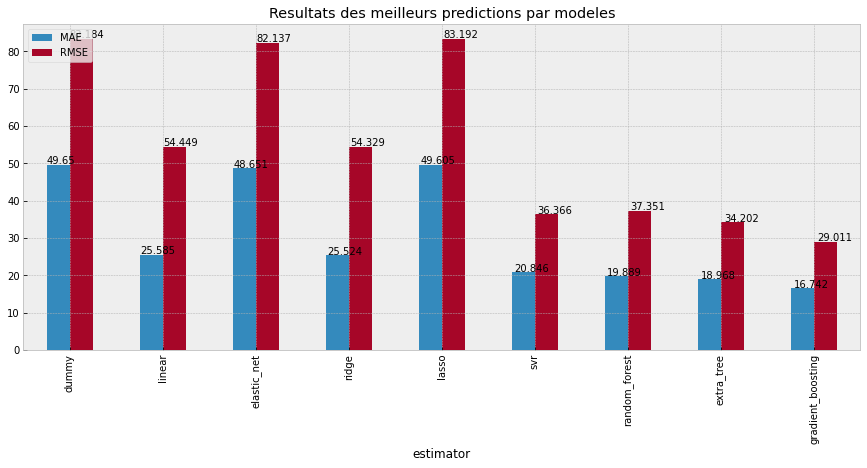

In [48]:
algo_estimatorDefaultsWithEnergy.getBestModeleScore_graphpredictions()

In [49]:
algo_estimatorWithEnergy = EstimatorSelectionByAlgo(models, params_models,True)
algo_estimatorWithEnergy.fit(X_train,y_train)

Running GridSearchCV for dummy.
training model DummyRegressor()
training dummy model done
elapsed time 0.51s
Running GridSearchCV for linear.
training model LinearRegression()
training linear model done
elapsed time 0.59s
Running GridSearchCV for elastic_net.
training model ElasticNet()
training elastic_net model done
elapsed time 8.97s
Running GridSearchCV for ridge.
training model Ridge(alpha=100000.0, fit_intercept=False)
training ridge model done
elapsed time 18.21s
Running GridSearchCV for lasso.
training model Lasso(alpha=100000.0, fit_intercept=False)
training lasso model done
elapsed time 18.46s
Running GridSearchCV for svr.
training model SVR()
training svr model done
elapsed time 11.51s
Running GridSearchCV for random_forest.
training model RandomForestRegressor()
training random_forest model done
elapsed time 4.81s
Running GridSearchCV for extra_tree.
training model ExtraTreesRegressor()
training extra_tree model done
elapsed time 2.60s
Running GridSearchCV for gradient_boos

In [50]:
algo_estimatorWithEnergy.getBestModeleScore_summary(True,showR2=True).compare(algo_estimatorDefaultsWithEnergy.getBestModeleScore_summary(showR2=True), align_axis=0).rename(index={'other': 'default parameter', 'self': 'custom parameter '})

R2     MAE     RMSE
estimator                                                    
dummy             custom parameter     0.139  57.424   94.916
                  default parameter    0.154  57.392   95.496
elastic_net       custom parameter     0.284  40.885   74.873
                  default parameter    0.091  55.230   92.940
ridge             custom parameter     0.625  72.779  112.822
                  default parameter  128.691  67.557  866.948
lasso             custom parameter     0.625  73.302  113.174
                  default parameter    0.153  57.295   95.466
svr               custom parameter     0.727  25.574   46.962
                  default parameter    0.698  27.698   49.045
random_forest     custom parameter     0.725  24.884   46.968
                  default parameter    0.722  24.905   47.262
extra_tree        custom parameter     0.716  24.701   47.593
                  default parameter    0.708  24.864   48.307
gradient_boosting custom parameter     0.767  22.485   43.420
                  default parameter    0.741  22.580   46.150

Clairement les modeles random_forest, extra_tree, et gradient boosting ont les meilleurs coefficient de determination , nous allons nous attarder sur ces 3 meilleurs modeles

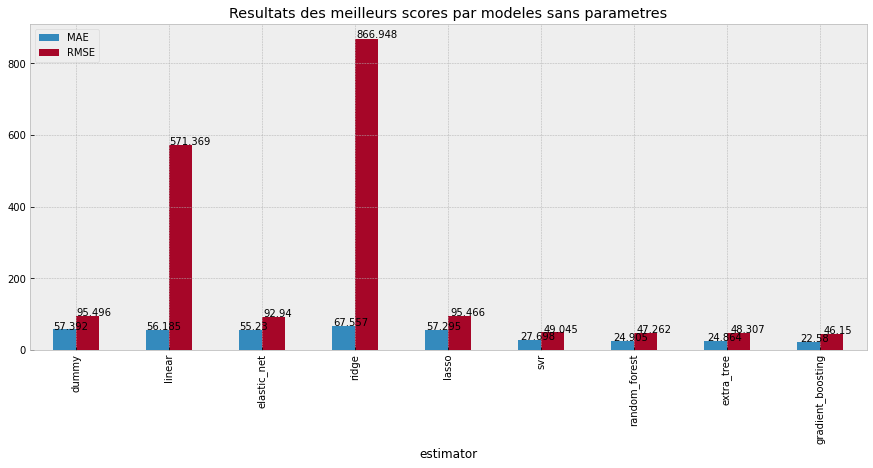

In [51]:
algo_estimatorDefaultsWithEnergy.getBestModeleScore_graph()

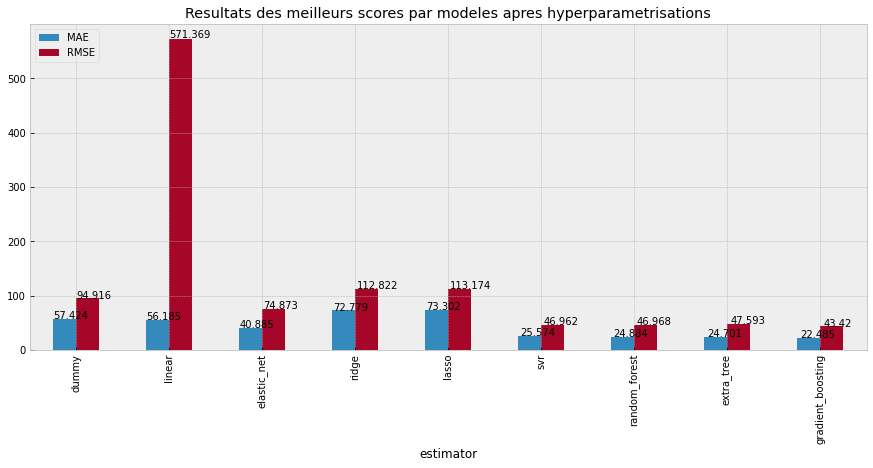

In [52]:
algo_estimatorWithEnergy.getBestModeleScore_graph()

Globalement nos resultats sont toujours meilleurs avec nos hyperparametres

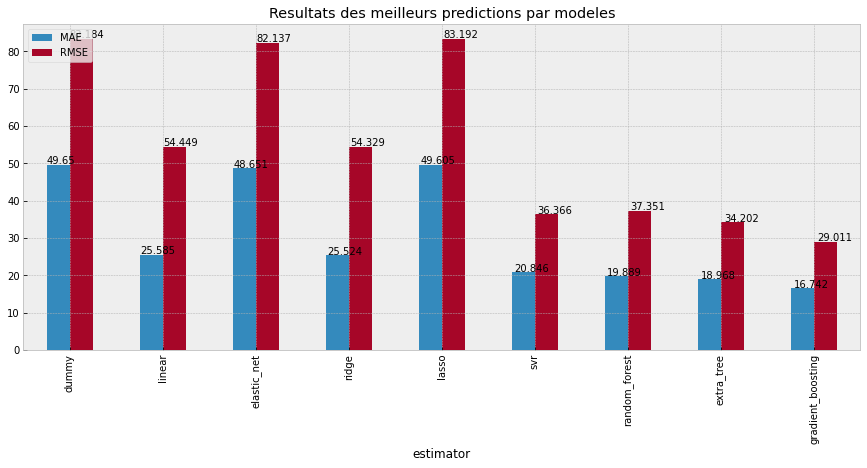

In [53]:
algo_estimatorDefaultsWithEnergy.getBestModeleScore_graphpredictions()

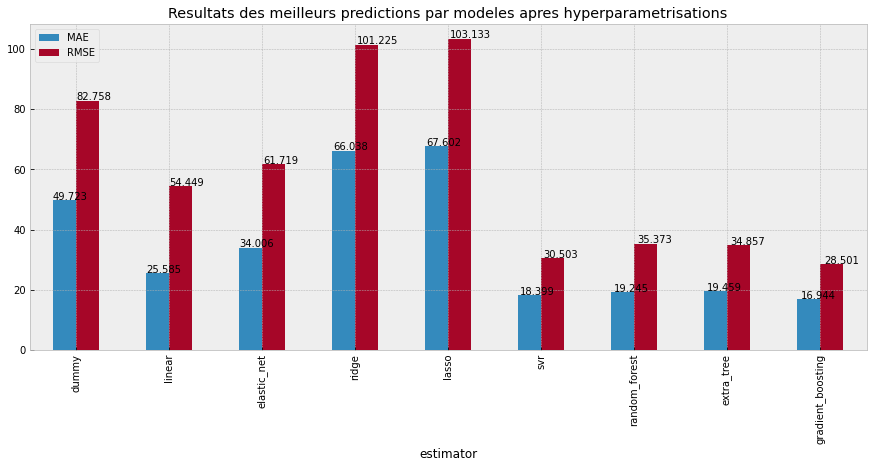

In [54]:
algo_estimatorWithEnergy.getBestModeleScore_graphpredictions()

In [55]:
algo_estimatorDefaultsWithEnergy.getBestModeleScore_scorePrediction(True,True)

R2     MAE    RMSE
estimator                                 
dummy             -0.11792  49.650  83.184
linear             0.52103  25.585  54.449
elastic_net       -0.08997  48.651  82.137
ridge              0.52313  25.524  54.329
lasso             -0.11814  49.605  83.192
svr                0.78634  20.846  36.366
random_forest      0.77461  19.889  37.351
extra_tree         0.81101  18.968  34.202
gradient_boosting  0.86403  16.742  29.011

<a name='sc'></a>
# Comparaisons des resultats 

**Compare les modeles avec EnergyStarScore avec hypeparametre et sans :**

In [56]:
algo_estimatorWithEnergy.getBestModeleScore_scorePrediction(True,True).compare(algo_estimatorDefaultsWithEnergy.getBestModeleScore_scorePrediction(True,True), align_axis=0).rename(index={'other': 'no option', 'self': 'with options '})

R2     MAE     RMSE
estimator                                                
dummy             with options  -0.10651  49.723   82.758
                  no option     -0.11792  49.650   83.184
elastic_net       with options   0.38457  34.006   61.719
                  no option     -0.08997  48.651   82.137
ridge             with options  -0.65543  66.038  101.225
                  no option      0.52313  25.524   54.329
lasso             with options  -0.71840  67.602  103.133
                  no option     -0.11814  49.605   83.192
svr               with options   0.84968  18.399   30.503
                  no option      0.78634  20.846   36.366
random_forest     with options   0.79785  19.245   35.373
                  no option      0.77461  19.889   37.351
extra_tree        with options   0.80370  19.459   34.857
                  no option      0.81101  18.968   34.202
gradient_boosting with options   0.86876  16.944   28.501
                  no option      0.86403  16.742   29.011

**Compare les modeles avec EnergyStarScore sans hypeparametres avec les modeles sans  EnergyStarScore sans hypeparametre:**

In [57]:
algo_estimatorDefaultsWithEnergy.getBestModeleScore_scorePrediction(True,True).compare(withoutparam , align_axis=0).rename(index={'other': 'without energy', 'self': ' with energy'}) 

R2     MAE     RMSE
estimator                                                 
dummy              with energy   -0.11792  49.650   83.184
                  without energy -0.12229  52.105   85.709
linear             with energy    0.52103  25.585   54.449
                  without energy -3.54234  48.053  172.432
elastic_net        with energy   -0.08997  48.651   82.137
                  without energy -0.08350  50.818   84.216
ridge              with energy    0.52313  25.524   54.329
                  without energy -8.47365  52.953  249.021
lasso              with energy   -0.11814  49.605   83.192
                  without energy -0.12229  52.105   85.709
svr                with energy    0.78634  20.846   36.366
                  without energy  0.57506  30.697   52.740
random_forest      with energy    0.77461  19.889   37.351
                  without energy  0.64600  26.268   48.137
extra_tree         with energy    0.81101  18.968   34.202
                  without energy  0.60638  27.082   50.759
gradient_boosting  with energy    0.86403  16.742   29.011
                  without energy  0.67617  26.102   46.040

**Compare les modeles avec EnergyStarScore avec hypeparametres avec les modeles sans  EnergyStarScore avec hypeparametre:**

In [58]:
algo_estimatorWithEnergy.getBestModeleScore_scorePrediction(True,True).compare(withParam, align_axis=0).rename(index={'other': 'options and no energy', 'self': 'options with energy'})

R2     MAE     RMSE
estimator                                                        
dummy             options with energy   -0.10651  49.723   82.758
                  options and no energy -0.11684  52.130   85.501
linear            options with energy    0.52103  25.585   54.449
                  options and no energy -3.54234  48.053  172.432
elastic_net       options with energy    0.38457  34.006   61.719
                  options and no energy -0.27416  40.437   91.325
ridge             options with energy   -0.65543  66.038  101.225
                  options and no energy -3.73979  47.567  176.139
lasso             options with energy   -0.71840  67.602  103.133
                  options and no energy -0.14196  38.926   86.457
svr               options with energy    0.84968  18.399   30.503
                  options and no energy  0.63124  28.203   49.130
random_forest     options with energy    0.79785  19.245   35.373
                  options and no energy  0.63037  26.328   49.188
extra_tree        options with energy    0.80370  19.459   34.857
                  options and no energy  0.60244  26.886   51.013
gradient_boosting options with energy    0.86876  16.944   28.501
                  options and no energy  0.67011  26.247   46.469

<a name='sl'></a>
# Selection des trois meilleurs algorithme

Jetons un coup d oeil sur les trois modeles les plus performants , a savoir <code>random forest, extra tree et gradient boosting</code>

estimator  \
6  random_forest   

                                                                                         best_params  
6  {'random_forest__regressor__max_features': 'auto', 'random_forest__regressor__n_estimators': 500}

estimator     R2     MAE    RMSE
6  random_forest  0.725  24.884  46.968

estimator       R2     MAE    RMSE
6  random_forest  0.79785  19.245  35.373

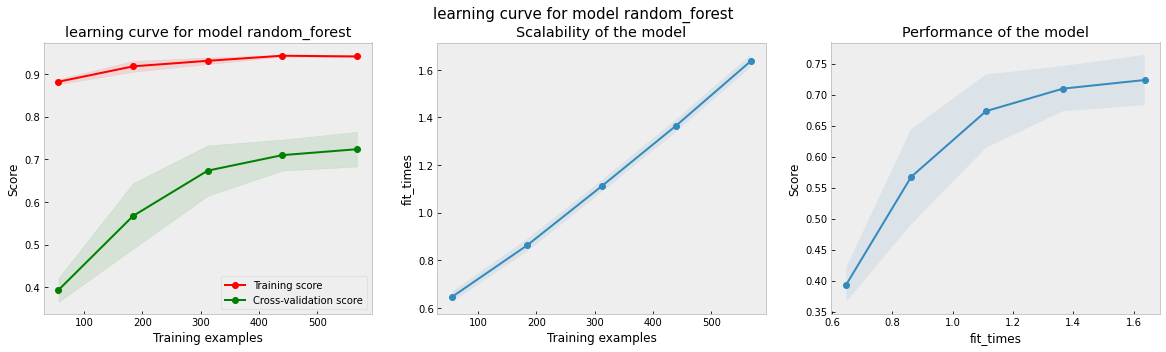

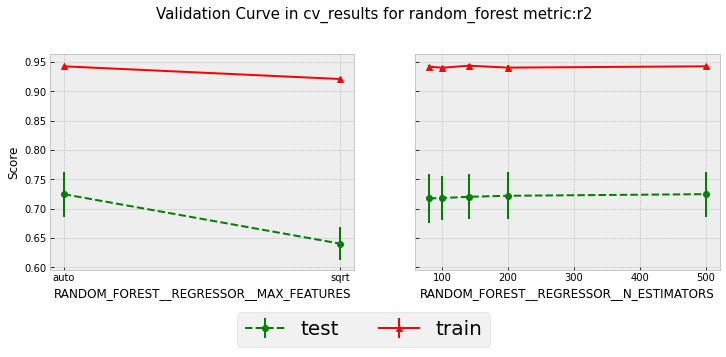

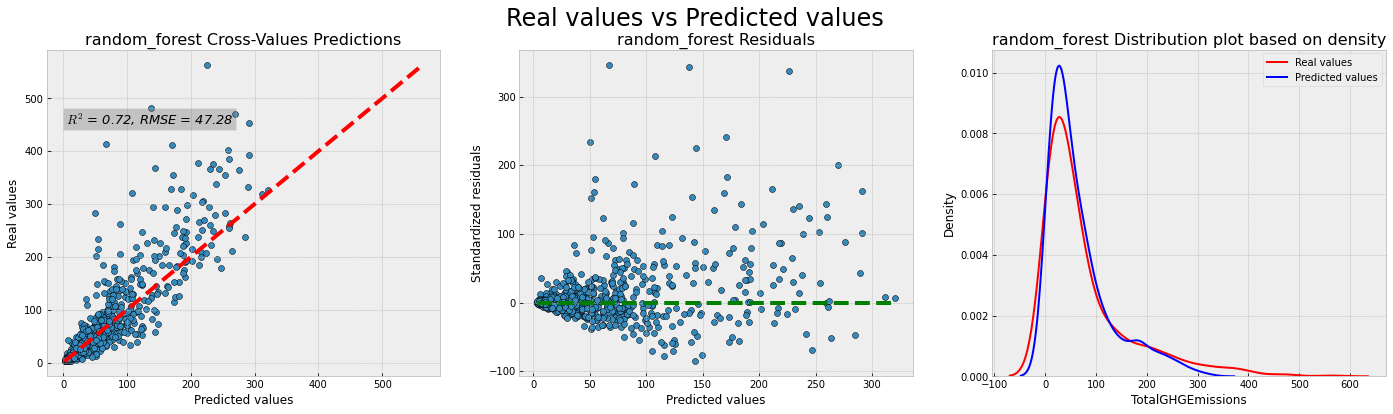

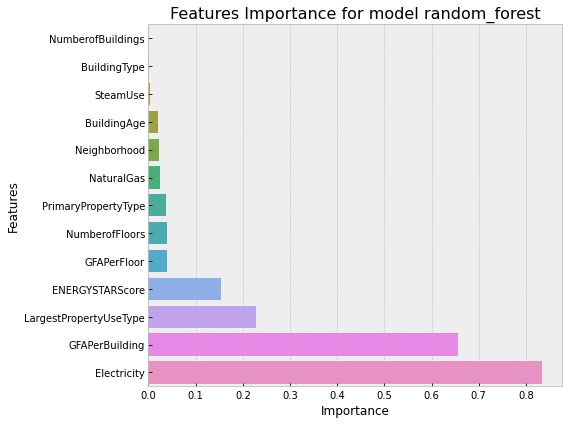

In [59]:
modele_name = 'random_forest'
algo_estimatorWithEnergy.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True)

estimator  \
7  extra_tree   

                                                                                                                              best_params  
7  {'extra_tree__regressor__bootstrap': False, 'extra_tree__regressor__min_samples_split': 4, 'extra_tree__regressor__n_estimators': 100}

estimator     R2     MAE    RMSE
7  extra_tree  0.716  24.701  47.593

estimator      R2     MAE    RMSE
7  extra_tree  0.8037  19.459  34.857

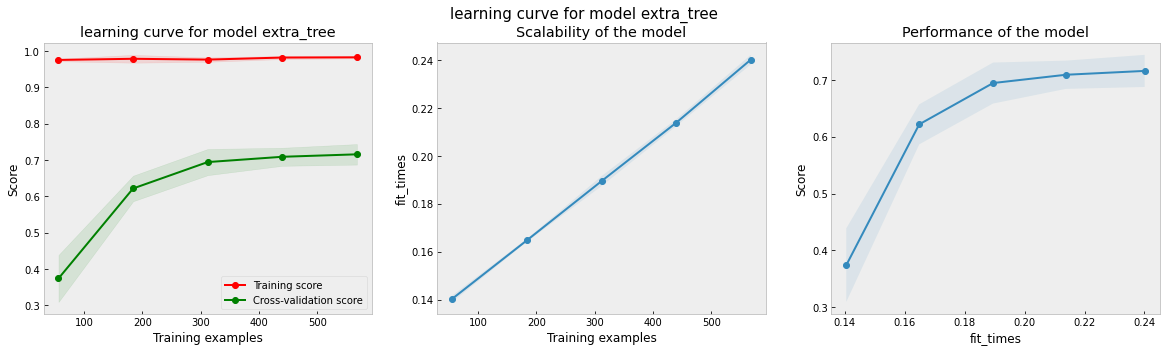

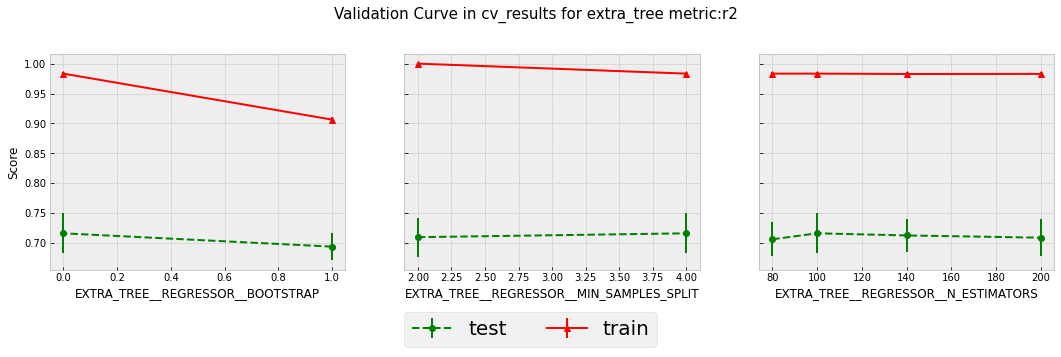

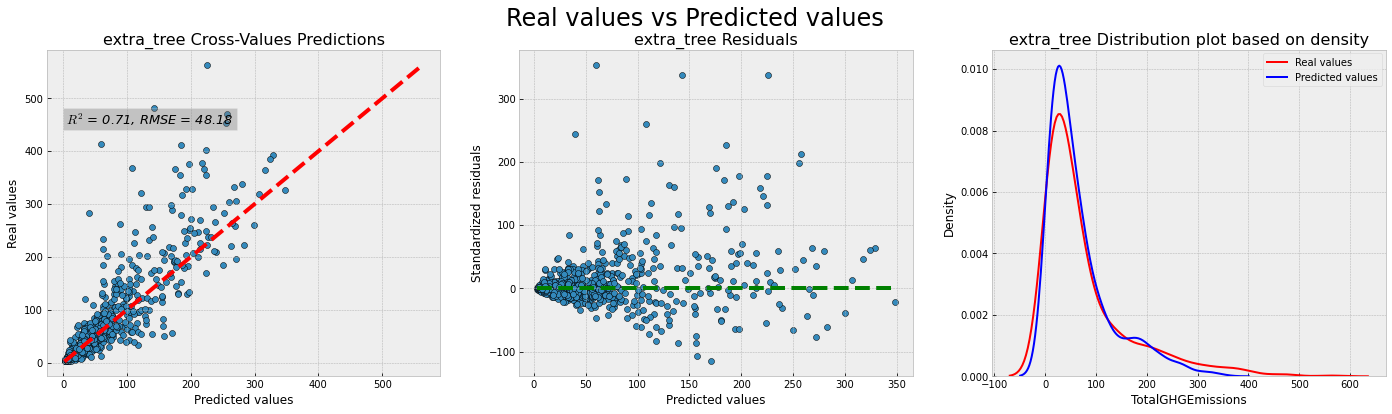

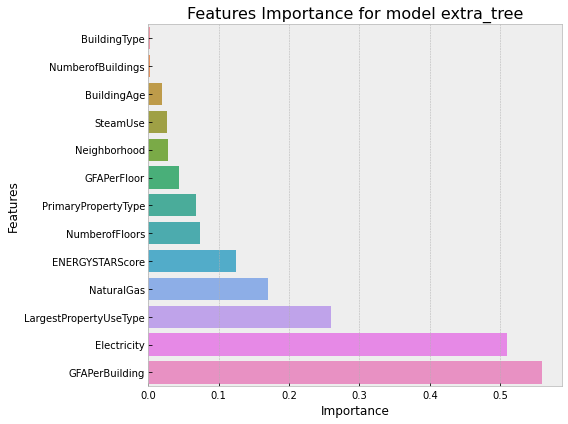

In [60]:
modele_name = 'extra_tree'
algo_estimatorWithEnergy.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True)

estimator  \
8  gradient_boosting   

                                                                                                                                                    best_params  
8  {'gradient_boosting__regressor__learning_rate': 0.01, 'gradient_boosting__regressor__max_leaf_nodes': 5, 'gradient_boosting__regressor__n_estimators': 1000}

estimator     R2     MAE   RMSE
8  gradient_boosting  0.767  22.485  43.42

estimator       R2     MAE    RMSE
8  gradient_boosting  0.86876  16.944  28.501

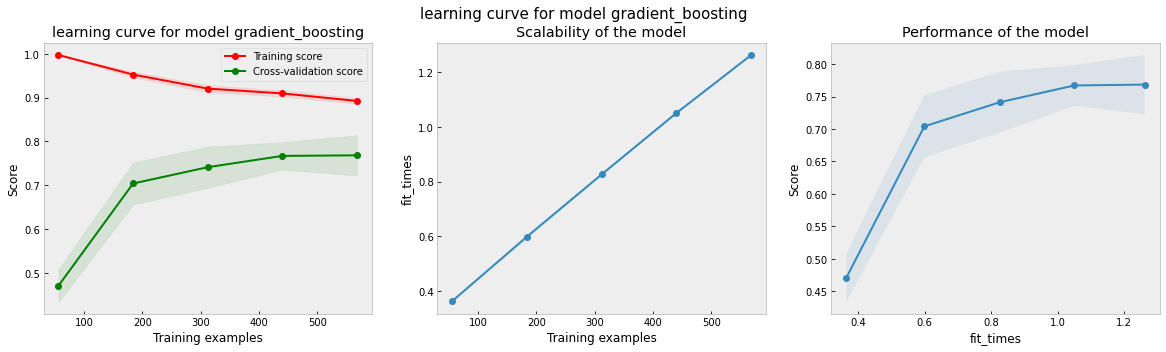

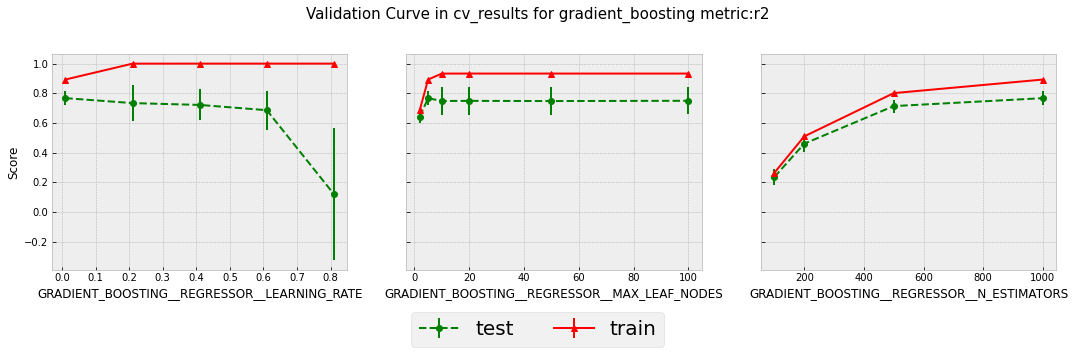

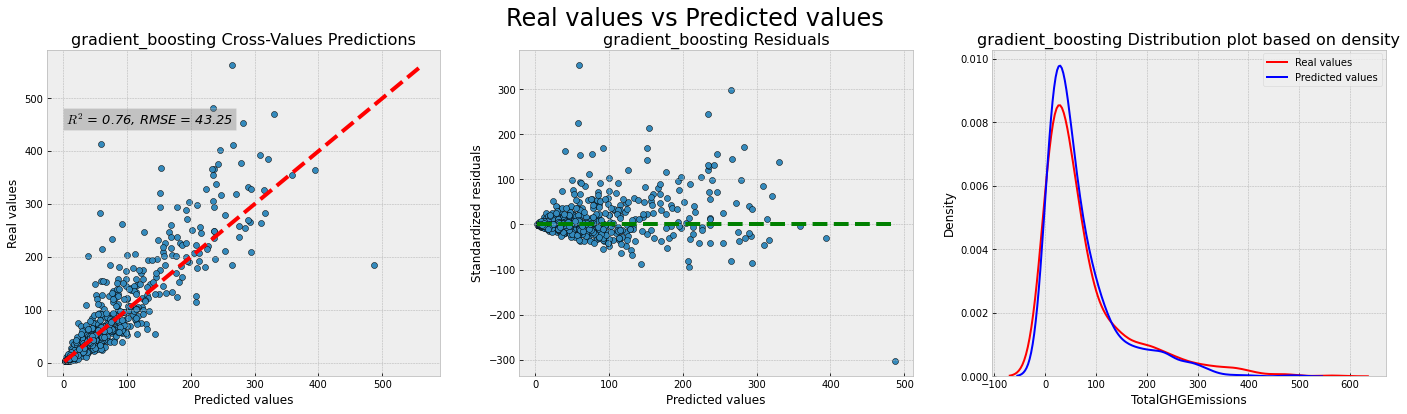

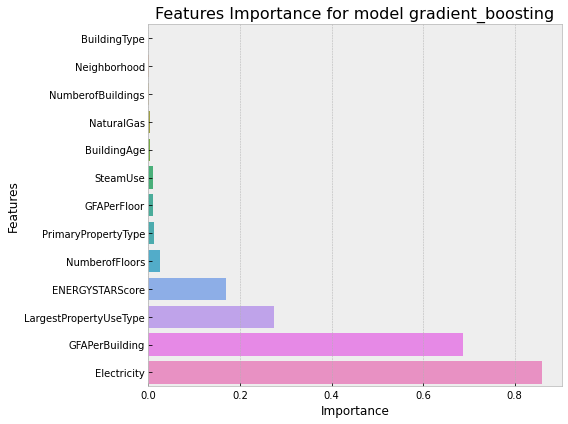

In [61]:
modele_name = 'gradient_boosting'
algo_estimatorWithEnergy.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True)

On peut remarquer que l ajout de la colonne energy star score a grandement influer sur les performances de nos modeles



Les métriques se sont améliorées grâce à la prise en compte de l'ENERGY STAR Score.

En revanche, cette variable est encore peu renseignée et le jeu de données comporte peu d'entrées. Il est donc difficile de savoir si cette amélioration est rééllement significative. Il faut également prendre en compte le bénéfice vis à vis du coût de cet ENERGY STAR Score.